In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/matt/readout/host/')
import ali_offline_demod as dm
import imp
import glob
import pickle
from scipy import spatial
import h5py
from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy
from scipy.interpolate import CubicSpline, interp1d

/tmp/ipykernel_2693/2322188046.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [65]:
#path to beam map data
main_folder = '/home/matt/ali_drive_mnt/beam_map_data/'

#beam map directory
directory = 'toneinit_fcenter_4250.0_20240308061355_t_20240308062133/'

#file
file = glob.glob(main_folder + directory + '*.hd5')[0]

print(file)


#open file
tes_data = h5py.File(file, 'r')

print(list(tes_data['time_ordered_data'].keys()))

#channel
channel = 100

#t = np.array(tes_data['time_ordered_data']['timestamp'])
i = np.array(tes_data['time_ordered_data']['adc_i'][100])
#q = np.array(tes_data['time_ordered_data']['adc_q'][channel,:])

print(i)



/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133/ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5
['adc_i', 'adc_q', 'timestamp']
[-336  121  411 ... -318  118  459]


In [66]:
processed_data = dm.full_demod_process('ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5',
                                       f_sawtooth=15,
                                       n=1,
                                       tone_init_path = '/home/matt/ali_drive_mnt/tone_initializations',
                                       ts_path = '/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133')
#normal demod process won't work because the datafile is too large; need to look at it in chunks

4250.0
20240308061355
/home/matt/ali_drive_mnt/tone_initializations/fcenter_4250.0_20240308061355/


MemoryError: Unable to allocate 59.4 GiB for an array with shape (1024, 15578912) and data type int32

In [16]:
#how many channels can we load at a time?

i = np.array(tes_data['time_ordered_data']['adc_i'][23:253][:])
print(i)

#python kernel begins to crash at around 200 channels, so let's chunck to 100 channels

# all we need to do is add an option to the top of the full demod process which channels to demod

[[-2040 -2937 -2973 ... -2047 -2954 -3003]
 [-1863 -1730 -2091 ... -1880 -1730 -2032]
 [  771   991  1765 ...   761   993  1772]
 ...
 [-1269 -1332 -1371 ... -1371 -1348 -1341]
 [  637  -138  -424 ...   126  -356  -512]
 [  216   -63  -199 ...    51  -180  -200]]


In [80]:
processed_data = dm.full_demod_process('ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5',
                                       f_sawtooth=15.0,
                                       n=2,
                                       channels='some',
                                       start_channel=190,
                                       stop_channel=192,
                                       tone_init_path = '/home/matt/ali_drive_mnt/tone_initializations',
                                       ts_path = '/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133')

4250.0
20240308061355
/home/matt/ali_drive_mnt/tone_initializations/fcenter_4250.0_20240308061355/
[4.04455676e+09+0.j 4.04925600e+09+0.j 4.05118850e+09+0.j
 4.05330762e+09+0.j 4.05590806e+09+0.j 4.05714651e+09+0.j
 4.05850391e+09+0.j 4.06022866e+09+0.j 4.06400279e+09+0.j
 4.06518536e+09+0.j 4.06691971e+09+0.j 4.06885077e+09+0.j
 4.07034654e+09+0.j 4.07258089e+09+0.j 4.07523714e+09+0.j
 4.07763186e+09+0.j 4.07906134e+09+0.j 4.08002344e+09+0.j
 4.08284868e+09+0.j 4.08409877e+09+0.j 4.08759989e+09+0.j
 4.08895191e+09+0.j 4.09030945e+09+0.j 4.09184880e+09+0.j
 4.09499819e+09+0.j 4.09772073e+09+0.j 4.09861800e+09+0.j
 4.10045020e+09+0.j 4.10217871e+09+0.j 4.10407520e+09+0.j
 4.10644922e+09+0.j 4.10902227e+09+0.j 4.11095010e+09+0.j
 4.11852755e+09+0.j 4.12088477e+09+0.j 4.12305392e+09+0.j
 4.12532650e+09+0.j 4.12841797e+09+0.j 4.12940020e+09+0.j
 4.13167971e+09+0.j 4.13445870e+09+0.j 4.13665958e+09+0.j
 4.13860275e+09+0.j 4.14014127e+09+0.j 4.14199198e+09+0.j
 4.14425367e+09+0.j 4.14628811e

  0%|          | 0/2 [00:00<?, ?it/s]

In [82]:
%matplotlib qt
#print(processed_data)

channel = [1]#np.arange(0,10,1)

for i in channel:
    plt.plot(processed_data['demod t'],processed_data['demod data'][i])

In [59]:
print(len(processed_data['demod data'][1]))
print(len(processed_data['fr data'][1]))

478583
15578912


In [111]:
#processing an entire beam map file

beam_map_directory = '/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133'
tone_init_path = '/home/matt/ali_drive_mnt/tone_initializations'
ts_file = glob.glob(f'{beam_map_directory}/*.hd5')[0]
print(ts_file)


#determine the number of channels using tone initialization
fcenter = beam_map_directory.split('_')[-4]
tone_init_t = beam_map_directory.split('_')[-3]
tone_init_directory = f'fcenter_{fcenter}_{tone_init_t}'
tone_init_freq_list = glob.glob(f'{tone_init_path}/{tone_init_directory}/freq_list_lo_sweep_targeted_1_*.npy')[0]
tones = np.load(tone_init_freq_list)
num_tones = len(tones)


if num_tones % 10 == 0:
    chunks = int(num_tones / 10)
else:
    chunks = int(num_tones // 10 + 1)

print(chunks)

for i in range(chunks):
    start_channel = start_channel + (stop_channel - start_channel)*i
    stop_channel = stop_channel + (stop_channel - start_channel)*i
    
    #truncated the final chunk if necessary
    if stop_channel > num_tones:
        stop_channel = num_tones
        
    processed_data = dm.full_demod_process(ts_file,
                                           f_sawtooth=15.0,
                                           n=2,
                                           channels='some',
                                           start_channel=start_channel,
                                           stop_channel=stop_channel,
                                           tone_init_path = tone_init_path,
                                           ts_path = beam_map_directory)
    
    #declare a filename for pickling
    file_name = 
    
    #pickle
    



#loop to read out and save to pickle files (need to name the pickle files using the channel ranges)


/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133/ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5


"\n#determine the number of channels using tone initialization\nfcenter = beam_map_directory.split('_')[-4]\ntone_init_t = beam_map_directory.split('_')[-3]\ntone_init_directory = f'fcenter_{fcenter}_{tone_init_t}'\ntone_init_freq_list = glob.glob(f'{tone_init_path}/{tone_init_directory}/freq_list_lo_sweep_targeted_1_*.npy')[0]\ntones = np.load(tone_init_freq_list)\nnum_tones = len(tones)\n\n\nif num_tones % 10 == 0:\n    chunks = int(num_tones / 10)\nelse:\n    chunks = int(num_tones // 10 + 1)\n\nprint(chunks)\n\nfor i in range(chunks):\n    start_channel = start_channel + (stop_channel - start_channel)*i\n    stop_channel = stop_channel + (stop_channel - start_channel)*i\n    \n    #truncated the final chunk if necessary\n    if stop_channel > num_tones:\n        stop_channel = num_tones\n        \n    processed_data = dm.full_demod_process('ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5',\n                                       f_sawtooth=15.0,\n                    

In [ ]:
#iv curves for 4250 MHz

# BL 9 - 20240212172504
iv_curve_file_4250MHz_BL9 = 'toneinit_fcenter_4250.0_20240212164634_t_20240212172504'

# BL 10 - 20240212171247
iv_curve_file_4250MHz_BL10 = 'toneinit_fcenter_4250.0_20240212164634_t_20240212171247'

# BL 11 - 20240212173240
iv_curve_file_4250MHz_BL11 = 'toneinit_fcenter_4250.0_20240212164634_t_20240212173240'



## Start Here

In [71]:
#process iv curve
iv_curves = {'4250MHz_BL9_Warm':'toneinit_fcenter_4250.0_20240212164634_t_20240212172504',
             '4250MHz_BL10_Warm':'toneinit_fcenter_4250.0_20240212164634_t_20240212171247',
             '4250MHz_BL11_Warm':'toneinit_fcenter_4250.0_20240212164634_t_20240212173240',
             '4750MHz_BL7_Warm':'toneinit_fcenter_4750.0_20240212174427_t_20240212174816',
             '4750MHz_BL8_Warm':'toneinit_fcenter_4750.0_20240212174427_t_20240212175959',
             '4750MHz_BL9_Warm':'toneinit_fcenter_4750.0_20240212174427_t_20240212180717',
             '4750MHz_BL11_Warm':'toneinit_fcenter_4750.0_20240212174427_t_20240212181437',
             '5250MHz_BL7_Warm':'toneinit_fcenter_5250.0_20240212182224_t_20240212182634', # -> problem here undiagnosed
             '5250MHz_BL9_Warm':'toneinit_fcenter_5250.0_20240212182224_t_20240212183347', # -> problem here
             '5250MHz_BL12_Warm':'toneinit_fcenter_5250.0_20240212182224_t_20240212184128',
             '5750MHz_BL8_Warm':'toneinit_fcenter_5750.0_20240212190328_t_20240212190721',
             '5750MHz_BL11_Warm':'toneinit_fcenter_5750.0_20240212190328_t_20240212191433',
             '6250MHz_BL8_Warm':'toneinit_fcenter_6250.0_20240212192226_t_20240212192618',
             '6750MHz_BL12_Warm':'toneinit_fcenter_6750.0_20240212193336_t_20240212193745',
             '4250MHz_BL9_Cold':'toneinit_fcenter_4250.0_20240213100705_t_20240213101047',
             '4250MHz_BL10_Cold':'toneinit_fcenter_4250.0_20240213100705_t_20240213101808',
             '4250MHz_BL11_Cold':'toneinit_fcenter_4250.0_20240213100705_t_20240213102551',
             '4750MHz_BL7_Cold':'toneinit_fcenter_4750.0_20240213103311_t_20240213103650',
             '4750MHz_BL8_Cold':'toneinit_fcenter_4750.0_20240213103311_t_20240213104400',
             '4750MHz_BL9_Cold':'toneinit_fcenter_4750.0_20240213103311_t_20240213105157',
             '4750MHz_BL11_Cold':'toneinit_fcenter_4750.0_20240213103311_t_20240213105928',
             '5250MHz_BL7_Cold':'toneinit_fcenter_5250.0_20240213110651_t_20240213111049',
             '5250MHz_BL9_Cold':'toneinit_fcenter_5250.0_20240213110651_t_20240213111823', #> problem here
             '5250MHz_BL12_Cold':'toneinit_fcenter_5250.0_20240213110651_t_20240213112541',
             '5750MHz_BL8_Cold':'toneinit_fcenter_5750.0_20240213114826_t_20240213115229',
             '5750MHz_BL11_Cold':'toneinit_fcenter_5750.0_20240213114826_t_20240213120017',
             '6250MHz_BL8_Cold':'toneinit_fcenter_6250.0_20240213120741_t_20240213121138',
             '6750MHz_BL12_Cold':'toneinit_fcenter_6750.0_20240213121929_t_20240213123317'}

#iv_processed_4250MHz_BL9 = dm.full_iv_process(iv_curves['4250MHz_BL9_Warm'],f_sawtooth=15, filter_Rn_Al=True, plot=None) 
iv_processed_4250MHz_BL10 = dm.full_iv_process(iv_curves['4250MHz_BL10_Warm'],f_sawtooth=15, filter_Rn_Al=True, plot=None) 
#iv_processed_4250MHz_BL11 = dm.full_iv_process(iv_curves['4250MHz_BL11_Warm'],f_sawtooth=15, filter_Rn_Al=True, plot=None) 

4250.0
20240212164634
/home/matt/alicpt_data/tone_initializations/fcenter_4250.0_20240212164634/
num of channels: 1002
num of tones: 235
looking for delay region
start = 4047472656.2500253
stop = 4057492187.5000253
3.2552083333333246
n_phi0: 3.2552083333333246
start index: 20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

ValueError: cannot convert float NaN to integer

In [69]:
#view IV curves - find a good one to examine

active_channel = [3] #range(len(iv_processed_4250MHz_BL10))

for ch in active_channel:
    plt.plot(iv_processed_4250MHz_BL10['Vtes'][ch],iv_processed_4250MHz_BL10['Ites'][ch])
    print(f'Channel: {ch} Frequency: {np.real(iv_processed_4250MHz_BL10["time series data"]["channel freqs"][ch])}')

NameError: name 'iv_processed_4250MHz_BL10' is not defined

In [3]:
#look at the good iv curve's ts data
imp.reload(dm)

#ts_toneinit_fcenter_4250.0_20240221163542_t_20240221164159
#ts_toneinit_fcenter_4250.0_20240221163542_t_20240221164021

#ts_file = 'ts_toneinit_fcenter_4250.0_20240221163542_t_20240221164159.hd5' # -> BL 10 with FTS source
#ts_file = 'ts_toneinit_fcenter_4250.0_20240216162215_t_20240216164412.hd5' # -> BL 10 with LN2 *****
#ts_file = 'ts_toneinit_fcenter_4250.0_20240221163542_t_20240221164021.hd5'
ts_file = 'ts_toneinit_fcenter_4250.0_20240506174818_t_20240506192250.hd5' # -> BL10 4250 MHz polarizer; note it takes a bit of time to process

#/home/matt/ali_drive_mnt/time_streams

test_ts_processed = dm.full_demod_process(ts_file,
                                          f_sawtooth=15.0,
                                          n=0,
                                          channels='all',
                                          tone_init_path = '/home/matt/ali_drive_mnt/tone_initializations', 
                                          ts_path = '/home/matt/ali_drive_mnt/time_streams')

4250.0
20240506174818
/home/matt/ali_drive_mnt/tone_initializations/fcenter_4250.0_20240506174818/
num of channels: 1002
num of tones: 233
looking for delay region


/home/matt/readout/host/ali_offline_demod.py:679: RuntimeWarning: divide by zero encountered in log10
  y=np.append(y,20*np.log10(np.abs(test_sweep[1,:])))


start = 4404608687.500062
stop = 4414628218.750062
3.2552083333333246
n_phi0: 3.2552083333333246
start index: 28


  0%|          | 0/233 [00:00<?, ?it/s]

In [73]:
#match channels from IV dataset to channels from TES source ts dataset
iv_freqs = iv_processed_4250MHz_BL10["time series data"]["channel freqs"]
ts_freqs = test_ts_processed["channel freqs"]

matched = dm.match_freqs(iv_freqs, ts_freqs)
print(matched[3])

[3 3]


/home/matt/readout/host/ali_offline_demod.py:1194: ComplexWarning: Casting complex values to real discards the imaginary part
  idups_ids=[fall[x,1].astype(int) for x in idups_redu]
/home/matt/readout/host/ali_offline_demod.py:1200: ComplexWarning: Casting complex values to real discards the imaginary part
  corrected_complex_data = apply_correction(eta_array, adc_i, adc_q)
/home/matt/readout/host/ali_offline_demod.py:1202: ComplexWarning: Casting complex values to real discards the imaginary part
  print(adc_q[22:25])


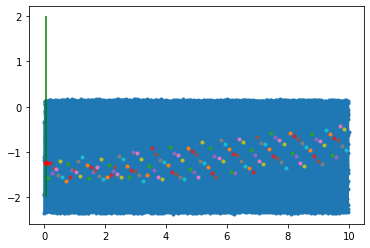

In [3]:
#view ts raw
active_channel = [3]#range(len(test_ts_processed['demod data']))
for ch in active_channel:
    plt.plot(test_ts_processed['fr t'], test_ts_processed['fr data'][ch],'.-')
    for i in test_ts_processed['reset indices']:
        plt.plot(test_ts_processed['fr t'][test_ts_processed['start index']+i], test_ts_processed['fr data'][ch][test_ts_processed['start index']+i],'.')
    plt.vlines(test_ts_processed['t0']+test_ts_processed['fr t'][0],-2,2,'g')
    plt.plot(test_ts_processed['fr t'][test_ts_processed['start index']], test_ts_processed['fr data'][ch][test_ts_processed['start index']],'r*')
    

In [4]:
ch = 3


for i in range(len(test_ts_processed['reset indices'])-2):
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][i]
    stop = test_ts_processed['reset indices'][i+2]
    plt.plot(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], test_ts_processed['fr data'][ch][start:stop],'.-')
    
#plt.plot(test_ts_processed['fr t'], test_ts_processed['fr data'][ch],'--')

NameError: name 'test_ts_processed' is not defined

In [143]:
#view ts processed
active_channel = [3]#range(len(test_ts_processed['demod data']))

for ch in active_channel:
    plt.plot(test_ts_processed['demod t'], test_ts_processed['demod data'][ch])
    print(f'Channel: {ch} Frequency: {np.real(test_ts_processed["channel freqs"][ch])}')

Channel: 3 Frequency: 4053295757.8125496


In [ ]:
processed_data = dm.full_demod_process('ts_toneinit_fcenter_4250.0_20240306105515_t_20240306110342.hd5',
                                       f_sawtooth=15.0,
                                       n=3,
                                       channels='some',
                                       start_channel=0,
                                       stop_channel=5,
                                       tone_init_path = '/home/matt/alicpt_data/tone_initializations',
                                       ts_path = '/home/matt/alicpt_data/beam_map_data/toneinit_fcenter_4250.0_20240306105515_t_20240306110300')

4250.0
20240306105515
/home/matt/alicpt_data/tone_initializations/fcenter_4250.0_20240306105515/
[4.09189751e+09+0.j 4.09497738e+09+0.j 4.09774300e+09+0.j
 4.09864544e+09+0.j 4.10049907e+09+0.j 4.10224419e+09+0.j]
num of channels: 6
num of tones: 6
looking for delay region


/home/matt/readout/host/ali_offline_demod.py:679: RuntimeWarning: divide by zero encountered in log10
  y=np.append(y,20*np.log10(np.abs(test_sweep[1,:])))


start = 4404106710.937561
stop = 4414126242.187561


In [10]:
#match channels from IV dataset to channels from beam mapper dataset

iv_freqs = iv_processed_4250MHz_BL10["time series data"]["channel freqs"]
bm_freqs = processed_data["channel freqs"]

matched = dm.match_freqs(iv_freqs, ts_freqs)
print(matched[3])

[3 3]


In [12]:
#view beam map raw
%matplotlib qt
active_channel = [3]#range(len(test_ts_processed['demod data']))

for ch in active_channel:
    plt.plot(processed_data['fr t'], processed_data['fr data'][ch])
    print(f'Channel: {ch} Frequency: {np.real(processed_data["channel freqs"][ch])}')

Channel: 3 Frequency: 4098645437.5000505


In [190]:
#view beam map processed
active_channel = [3]#range(len(test_ts_processed['demod data']))

for ch in active_channel:
    plt.plot(processed_data['demod t'], processed_data['demod data'][ch])
    print(f'Channel: {ch} Frequency: {np.real(processed_data["channel freqs"][ch])}')

Channel: 3 Frequency: 4098645437.5000505


In [112]:
#chao-lin's interpolation idea

#generate flux ramp signal that matches the parameters we used during testing (this is for visuals)

fig, ax = plt.subplots(1)

sample_rate = 1000 #samples/s
start_t = 0 #s
end_t = 2/15 #s

f_sawtooth = 15 #Hz
n_Phi0 = 3.2368701718642683

t = np.arange(start_t,end_t,1/sample_rate)


t_fr, fr = dm.generate_flux_ramp(t, n_Phi0=n_Phi0, f_sawtooth=f_sawtooth, plot = False, plot_len = None)
average_fr = np.average(fr)


ax.plot(t_fr,fr-average_fr)

ch = 3


for i in range(len(test_ts_processed['reset indices'])-2):
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][i]
    stop = test_ts_processed['reset indices'][i+2]
    average = np.average(test_ts_processed['fr data'][ch])
    ax.plot(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], test_ts_processed['fr data'][ch][start:stop]-average,'.-')
    

In [113]:
from scipy.interpolate import CubicSpline, interp1d

fig, ax = plt.subplots(1)

t_fr, fr = dm.generate_flux_ramp(t, n_Phi0=n_Phi0, f_sawtooth=f_sawtooth, plot = False, plot_len = None)
average_fr = np.average(fr)

ax.plot(t_fr,fr-average_fr)

demod_data = np.array([])
demod_t = np.array([])
for i in [0]:#range(len(test_ts_processed['reset indices'])-2):
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][i]
    stop = test_ts_processed['reset indices'][i+2]
    average = np.average(test_ts_processed['fr data'][ch])
    
    interpolation = CubicSpline(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], 
                                test_ts_processed['fr data'][ch][start:stop]-average)
    t_new = np.linspace(0,test_ts_processed['fr t'][stop]-test_ts_processed['fr t'][start],1024)
    
    ax.plot(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], 
            test_ts_processed['fr data'][ch][start:stop]-average,
            '*')
    
    t_windowed = t_new#t_new[:len(t_new)-200]
    interp_windowed = interpolation(t_new)#[:len(t_new)-200]
    
    ax.plot(t_windowed,interp_windowed,'.-')
    
    num = np.sum(interp_windowed*np.sin(2*np.pi*n_Phi0*f_sawtooth*t_windowed))
    den = np.sum(interp_windowed*np.cos(2*np.pi*n_Phi0*f_sawtooth*t_windowed))
    
    
    #num = np.sum(interpolation(t_new)*np.sin(2*np.pi*n_Phi0*f_sawtooth*t_new))
    #den = np.sum(interpolation(t_new)*np.cos(2*np.pi*n_Phi0*f_sawtooth*t_new))
    
    demod_data = np.append(demod_data, np.arctan2(num, den))
    demod_t = np.append(demod_t, np.average(test_ts_processed['fr t'][start:stop])) #simple test is to make time the average time in the chunk

fig2, ax2 = plt.subplots(1)
ax2.plot(demod_t, demod_data,'.-')
    
    
    

In [114]:
"""
next steps:

single channel, break down the entire process step by step manually

1: define a good t0
2: identify all of the flux ramp reset points
3: attempt to demodulate on each resulting chunk
   a. use 1024 points or a smaller power of 2
   b. use actual fft to get first 3 terms
   c. reinject phase (try to reproduce the original data exactly)
   
   add to doc:
   synchronize the fr and detector sampling
   time spacing
"""

#raw data
fig, ax = plt.subplots(1)
ax.plot(test_ts_processed['fr t'], test_ts_processed['fr data'][3],'.-')

#manually setting t0 to the 28th pt
t_t0shifted = test_ts_processed['fr t'][28:]
fr_t0shifted = test_ts_processed['fr data'][3][28:]
fig2, ax2 = plt.subplots(1)
ax2.plot(t_t0shifted,fr_t0shifted,'.-')

In [115]:
#trying out fft fitting method

from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy

#first an initial test of the fft with a simple sine wave

sample_rate = 10 #Hz
frequency = 1 #Hz
phi = 0 #rad

t = np.arange(0,10,1/sample_rate)
signal = np.exp(-0.1*t)*np.sin(frequency*t+phi)


plt.plot(t,signal,'.')


signal_fft = fft(signal)

first_term = deepcopy(signal_fft)

np.put(first_term, np.arange(1,len(signal_fft),1).astype(int), 0.0)

first_term_ifft = ifft(first_term)

plt.plot(t, first_term_ifft,label='one term')

first_two_terms = deepcopy(signal_fft)
np.put(first_two_terms, np.arange(2,len(signal_fft),1).astype(int), 0.0)

first_two_terms_ifft = ifft(first_two_terms)

plt.plot(t, first_two_terms_ifft,label='two terms')

first_three_terms = deepcopy(signal_fft)
np.put(first_three_terms, np.arange(3,len(signal_fft),1).astype(int), 0.0)

first_three_terms_ifft = ifft(first_three_terms)

plt.plot(t, first_three_terms_ifft,label='three terms')

all_terms_ifft = ifft(signal_fft)
plt.plot(t, all_terms_ifft,label=f'{len(t)} terms (all)')

plt.legend()



In [116]:
#fft fitting method on our data
%matplotlib qt


fig, ax = plt.subplots(1)
ch = 3
ax.plot(test_ts_processed['fr t'],test_ts_processed['fr data'][ch],'.-')

#chunk and overplot
fig2, ax2 = plt.subplots(1)
for chunk in [0]:#range(len(test_ts_processed['reset indices'])-2):
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][chunk]
    stop = test_ts_processed['reset indices'][chunk+2]
    average = np.average(test_ts_processed['fr data'][ch])
    ax2.plot(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], test_ts_processed['fr data'][ch][start:stop]-average,'.-')
    
#interpolate (i.e., rebin)
fig3, ax3 = plt.subplots(1)
for chunk in [0]:#range(len(test_ts_processed['reset indices'])-2):
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][chunk]
    stop = test_ts_processed['reset indices'][chunk+2]
    average = np.average(test_ts_processed['fr data'][ch])
    
    interpolation = CubicSpline(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], 
                                test_ts_processed['fr data'][ch][start:stop]-average)
    t_new = np.linspace(0,test_ts_processed['fr t'][stop]-test_ts_processed['fr t'][start],1024)
    
    ax3.plot(t_new, interpolation(t_new),'.-')
    
#fit with fft

fig4, ax4 = plt.subplots(1)
for chunk in [0]:#range(len(test_ts_processed['reset indices'])-2):
    
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][chunk]
    stop = test_ts_processed['reset indices'][chunk+2]
    average = np.average(test_ts_processed['fr data'][ch])
    
    interpolation = CubicSpline(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], 
                                test_ts_processed['fr data'][ch][start:stop]-average)
    t_new = np.linspace(0,test_ts_processed['fr t'][stop]-test_ts_processed['fr t'][start],1024)
    
    ax4.plot(t_new, interpolation(t_new),'.')

    fft_interpolation = fft(interpolation(t_new))
    
    first_term = deepcopy(fft_interpolation)
    np.put(first_term,np.arange(1,len(fft_interpolation),1),0.0)
    first_term_ifft = ifft(first_term)

    first_two_terms = deepcopy(fft_interpolation)
    np.put(first_two_terms,np.arange(2,len(fft_interpolation),1),0.0)
    first_two_terms_ifft = ifft(first_two_terms)

    first_three_terms = deepcopy(fft_interpolation)
    np.put(first_three_terms,np.arange(3,len(fft_interpolation),1),0.0)
    first_three_terms_ifft = ifft(first_three_terms)
    
    first_ten_terms = deepcopy(fft_interpolation)
    np.put(first_ten_terms,np.arange(10,len(fft_interpolation),1),0.0)
    first_ten_terms_ifft = ifft(first_ten_terms)
    
    first_twenty_terms = deepcopy(fft_interpolation)
    np.put(first_twenty_terms,np.arange(20,len(fft_interpolation),1),0.0)
    first_twenty_terms_ifft = ifft(first_twenty_terms)
    
    first_onehundred_terms = deepcopy(fft_interpolation)
    np.put(first_onehundred_terms,np.arange(100,len(fft_interpolation),1),0.0)
    first_onehundred_terms_ifft = ifft(first_onehundred_terms)
    
    first_onethousand_terms = deepcopy(fft_interpolation)
    np.put(first_onethousand_terms,np.arange(1000,len(fft_interpolation),1),0.0)
    first_onethousand_terms_ifft = ifft(first_onethousand_terms)
           
    
    all_terms_ifft = ifft(fft_interpolation)
    
    ax4.plot(t_new, first_term_ifft, label = 'n = 1')
    ax4.plot(t_new, first_two_terms_ifft, label = 'n = 2')
    ax4.plot(t_new, first_three_terms_ifft, label = 'n = 3')
    ax4.plot(t_new, first_ten_terms_ifft, label = 'n = 10')
    ax4.plot(t_new, first_twenty_terms_ifft, label = 'n = 20')
    ax4.plot(t_new, first_onehundred_terms_ifft, label = 'n = 100')
    ax4.plot(t_new, first_onethousand_terms_ifft, label = 'n = 1000')
    ax4.plot(t_new, all_terms_ifft, label = f'n = {len(fft_interpolation)} (all)')
    ax4.legend()


In [117]:
"""
After more conversations with Chao-Lin:

1. Need to zero pad (same length as original vector)
2. Look at the fft in frequency space; keep first 3 real terms
"""

fig, ax = plt.subplots(1)
fig2, ax2 = plt.subplots(1)
fig3, ax3 = plt.subplots(1)
for chunk in [0]:#range(len(test_ts_processed['reset indices'])-2):
    
    start = test_ts_processed['start index'] + test_ts_processed['reset indices'][chunk]
    stop = test_ts_processed['reset indices'][chunk+2]
    average = np.average(test_ts_processed['fr data'][ch])
    
    interpolation = CubicSpline(test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start], 
                                test_ts_processed['fr data'][ch][start:stop]-average)
    t_interp = np.linspace(0,test_ts_processed['fr t'][stop]-test_ts_processed['fr t'][start],1024)
    sig_interp = interpolation(t_interp)
    
    t_zero_pad = np.linspace(0,(test_ts_processed['fr t'][stop]-test_ts_processed['fr t'][start])*2,len(t_interp)*2)
    sig_zero_pad = np.append(sig_interp, np.zeros(len(sig_interp)))
    
    print(len(t_interp))
    print(len(sig_interp))
    print(len(t_zero_pad))
    print(len(sig_zero_pad))
    print(t_zero_pad)
    print(sig_zero_pad)
    
    ax.plot(t_interp, sig_interp,'.',label='interpolation')
    ax.plot(t_zero_pad, sig_zero_pad,'*',label='zero padded')

    fft_zero_pad = fft(sig_zero_pad)
    
    fftfreqs_zero_pad = fftfreq(len(sig_zero_pad), np.median(np.diff(t_zero_pad)))
    
    print(fft_zero_pad)
    
    print(fftfreqs_zero_pad)
    
    ax2.stem(fftfreqs_zero_pad, np.abs(fft_zero_pad))
    
    print(np.argmax(np.abs(fft_zero_pad)))
    
    fundamental_index = np.argmax(np.abs(fft_zero_pad))
    fundamental_freq = fftfreqs_zero_pad[fundamental_index]
    print(fundamental_freq)
    
    n1_fft = deepcopy(fft_zero_pad)
    np.put(n1_fft, np.arange(0,fundamental_index), 0.0)
    np.put(n1_fft, np.arange(fundamental_index+1, len(n1_fft)), 0.0)
    
    n1 = ifft(n1_fft) 
    
    ax.plot(t_zero_pad, n1)
    
    first_harmonic_index = fundamental_index * 2
    first_harmonic_freq = fftfreqs_zero_pad[first_harmonic_index]
    print(first_harmonic_freq)
    
    n2_fft = deepcopy(fft_zero_pad)
    np.put(n2_fft, np.arange(0,fundamental_index), 0.0)
    np.put(n2_fft, np.arange(fundamental_index+1,first_harmonic_index), 0.0)
    np.put(n2_fft, np.arange(first_harmonic_index+1,len(n2_fft)), 0.0)
    
    n2 = ifft(n2_fft)
    
    ax.plot(t_zero_pad, n2)
    
    nall = ifft(fft_zero_pad)
    
    ax.plot(t_zero_pad, nall)
        
    

ax2.set_xlim([0,100])
    
    
#next build a function that can build up to a desired number of terms and plot them    
    

1024
1024
2048
2048
[0.00000000e+00 7.40361505e-05 1.48072301e-04 ... 1.51403928e-01
 1.51477964e-01 1.51552000e-01]
[-0.33049692 -0.29080747 -0.25174734 ...  0.          0.
  0.        ]
[ 88.12417917 -0.j         -25.71196238+20.01709101j
 139.62498252 +3.9086978j  ... -38.30440106+19.13361391j
 139.62498252 -3.9086978j  -25.71196238-20.01709101j]
[  0.           6.5951734   13.1903468  ... -19.78552019 -13.1903468
  -6.5951734 ]
7
46.16621378305799
92.33242756611598


(0.0, 100.0)

In [118]:
def fft_fit(t, data, n):
    data_fft = fft(data)
    freqs = fftfreq(len(data), np.median(np.diff(t)))
    
    fundamental_idx = np.argmax(np.abs(data_fft))
    print(f'fundamental index: {fundamental_idx}')
    
    multiplication_factors = np.arange(1,n+1,1)
    #print(multiplication_factors)
    fundamental_array = np.ones(n)*fundamental_idx
    #print(fundamental_array)
    preserve_idxs = (multiplication_factors * fundamental_array).astype(int)
    #print(preserve_idxs)

    mask = np.zeros(len(data_fft))
    np.put(mask,preserve_idxs,1.0)
    
    n_limited_fft = data_fft * mask
    
    n_limited_fit = ifft(n_limited_fft)
    
    full_fit = ifft(data_fft)
    
    return freqs, data_fft, n_limited_fft, t, full_fit, n_limited_fit

fig, ax = plt.subplots(1)
fig2, (ax2_upper, ax2_lower) = plt.subplots(2)

ax.plot(t_zero_pad, sig_zero_pad,'.',label='Raw Data')

for n in np.arange(1,21,1):
    freqs, data_fft, n_limited_fft, t, full_fit, n_limited_fit = fft_fit(t_zero_pad, sig_zero_pad, n)
    ax.plot(t_zero_pad, n_limited_fit,label=f'n = {n}')
    ax2_lower.stem(freqs, np.abs(n_limited_fft))
    


ax.plot(t, full_fit,'-.',label='all fft terms')
ax2_upper.stem(freqs, np.abs(data_fft))


ax.set_xlabel('t (s)')
ax.set_ylabel('Amplitude (arb.)')
ax.legend()

ax2_lower.set_xlim([-0.01,500])
ax2_upper.set_xlim([-0.01,500])
ax2_lower.set_xlabel('Frequency (Hz)')
ax2_lower.set_ylabel('Amplitude (arb.)')
ax2_upper.set_ylabel('Amplitude (arb.)')

fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7
fundamental index: 7


Text(0, 0.5, 'Amplitude (arb.)')

In [119]:
fundamental_idx = 10
n = 20

multiplication_factors = np.arange(1,n+1,1)
fundamental_array = np.ones(n)*fundamental_idx
preserve_idxs = (multiplication_factors * fundamental_array).astype(int)
print(preserve_idxs)

#mask = np.zeros(len(data_fft))
#np.put(mask,preserve_idxs,1.0)
#print(mask)

#print(preserve_idxs)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]


In [149]:
"""
Next steps:
1. cut the reset region
2. zero pad (2N points)
3. fft fit as we have been doing (useful to plot real, imaginary, and abs)
4. Bin back to N points
"""
chunk = 0
zero_pad_multiple = 2

start = test_ts_processed['start index'] + test_ts_processed['reset indices'][chunk]
stop = test_ts_processed['reset indices'][chunk+2]
average = np.average(test_ts_processed['fr data'][ch])

t_chunk = test_ts_processed['fr t'][start:stop]-test_ts_processed['fr t'][start]
sig_chunk = test_ts_processed['fr data'][ch][start:stop]-average

fig, ax = plt.subplots(1)
ax.plot(t_chunk,sig_chunk,'.--')
ax.set_xlabel('t (s)')
ax.set_ylabel('Amplitude (arb.)')
ax.set_title('Single FR Raw Data')

t_reset_removed = t_chunk[:-5] #just manually removing the reset for right now
sig_reset_removed = sig_chunk[:-5]

fig2, ax2 = plt.subplots(1)
ax2.plot(t_reset_removed,sig_reset_removed,'.--')
ax2.set_xlabel('t (s)')
ax2.set_ylabel('Amplitude (arb.)')
ax2.set_title('Reset Removed')

interpolation = CubicSpline(t_reset_removed,sig_reset_removed)

t_interp = np.linspace(0,t_reset_removed[-1]-t_reset_removed[0],1024)
sig_interp = interpolation(t_interp)

fig3, ax3 = plt.subplots(1)
ax3.plot(t_interp, sig_interp,'.')
ax3.set_xlabel('t (s)')
ax3.set_ylabel('Amplitude (arb.)')
ax3.set_title('N = 1024 pt. Cubic Spline Interpolation')

print(t_interp)
t_zero_pad = np.linspace(0,2*(t_interp[-1]-t_interp[0]),2*len(t_interp))#np.linspace(0,(t_interp[-1]-t_interp[0]),len(t_interp)*zero_pad_multiple)
print(t_zero_pad)
sig_zero_pad = np.append(sig_interp, np.zeros(len(sig_interp)*(zero_pad_multiple-1)))

fig4, ax4 = plt.subplots(1)
ax4.plot(t_zero_pad,sig_zero_pad,'.')
ax4.set_xlabel('t (s)')
ax4.set_ylabel('Amplitude (arb.)')
ax4.set_title(f'Zero Pad to {zero_pad_multiple}*N = {zero_pad_multiple*1024} pts.')

#make and check ffts
fig5, ax5 = plt.subplots(1) #fits with 2*N fft
fig6, (ax6_upper,ax6_lower) = plt.subplots(2) #2*N fft in freq space
fig7, ax7 = plt.subplots(1) #fits with N fft
fig8, (ax8_upper,ax8_lower) = plt.subplots(2) #N fft in freq space

ax5.plot(t_zero_pad,sig_zero_pad,'.',label='data')
ax7.plot(t_interp,sig_interp,'.',label='data')

first = 0
for n in np.arange(1,11,1):
    freqs, data_fft, n_limited_fft, t, full_fit, n_limited_fit = fft_fit(t_zero_pad, sig_zero_pad, n)
    ax5.plot(t_zero_pad, n_limited_fit,label=f'n = {n}')
    if first == 0:
        ax6_upper.stem(freqs, np.abs(n_limited_fft),'b', markerfmt='bo',label='abs')
        ax6_upper.stem(freqs, np.real(n_limited_fft),'r', markerfmt='ro',label='real')
        ax6_upper.stem(freqs, np.imag(n_limited_fft),'g', markerfmt='go',label='imag')
    else:
        ax6_upper.stem(freqs, np.abs(n_limited_fft),'b', markerfmt='bo')
        ax6_upper.stem(freqs, np.real(n_limited_fft),'r', markerfmt='ro')
        ax6_upper.stem(freqs, np.imag(n_limited_fft),'g', markerfmt='go')
    
    #bin back to n points
    freqs_rebinned = [np.average([freqs[i], freqs[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
    data_fft_rebinned = [np.average([data_fft[i], data_fft[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
    full_fit_rebinned = ifft(data_fft_rebinned)
    t_rebinned = t_interp#t_zero_pad[:int(len(t_zero_pad)/2)]
    n_limited_fft_rebinned = [np.average([n_limited_fft[i], n_limited_fft[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
    n_limited_fit_rebinned = ifft(n_limited_fft_rebinned)
    
    ax7.plot(t_rebinned, n_limited_fit_rebinned,label=f'n = {n}')
    if first == 0:
        ax8_upper.stem(freqs_rebinned, np.abs(n_limited_fft_rebinned),'b', markerfmt='bo',label='abs')
        ax8_upper.stem(freqs_rebinned, np.real(n_limited_fft_rebinned),'r', markerfmt='ro',label='real')
        ax8_upper.stem(freqs_rebinned, np.imag(n_limited_fft_rebinned),'g', markerfmt='go',label='imag')
    else:
        ax8_upper.stem(freqs_rebinned, np.abs(n_limited_fft_rebinned),'b', markerfmt='bo')
        ax8_upper.stem(freqs_rebinned, np.real(n_limited_fft_rebinned),'r', markerfmt='ro')
        ax8_upper.stem(freqs_rebinned, np.imag(n_limited_fft_rebinned),'g', markerfmt='go')

    first = 1
    
ax5.plot(t,full_fit,'-.',label='n = all')
    
ax6_lower.stem(freqs, np.abs(data_fft),'b', markerfmt='bo',label='abs')
ax6_lower.stem(freqs, np.real(data_fft),'r', markerfmt='ro',label='real')
ax6_lower.stem(freqs, np.imag(data_fft),'g', markerfmt='go',label='imag')
    
ax7.plot(t_rebinned,full_fit_rebinned,'-.',label='n = all')

ax8_lower.stem(freqs_rebinned, np.abs(data_fft_rebinned),'b', markerfmt='bo',label='abs')
ax8_lower.stem(freqs_rebinned, np.real(data_fft_rebinned),'r', markerfmt='ro',label='real')
ax8_lower.stem(freqs_rebinned, np.imag(data_fft_rebinned),'g', markerfmt='go',label='imag')
    
    
    
ax5.legend()
ax5.set_xlabel('t (s)')
ax5.set_ylabel('Amplitude (arb.)')
ax5.set_title('Data Fitting without Rebinning')
    
ax6_upper.set_xlim([-0.5,500])
ax6_lower.set_xlim([-0.5,500])
ax6_upper.legend()
ax6_lower.legend()
ax6_lower.set_xlabel('Frequency (Hz)')
ax6_lower.set_ylabel('Amplitude (arb.)')
ax6_upper.set_ylabel('Amplitude (arb.)')

ax7.legend()
ax7.set_xlabel('t (s)')
ax7.set_ylabel('Amplitude (arb.)')
ax7.set_title('Data Fitting with Rebinning')

ax8_upper.set_xlim([-0.5,500])
ax8_lower.set_xlim([-0.5,500])
ax8_upper.legend()
ax8_lower.legend()
ax8_lower.set_xlabel('Frequency (Hz)')
ax8_lower.set_ylabel('Amplitude (arb.)')
ax8_upper.set_ylabel('Amplitude (arb.)')


#check fits
#fig7, ax7 = plt.subplots(1)



#fig7, 

[0.00000000e+00 6.20606061e-05 1.24121212e-04 ... 6.33638788e-02
 6.34259394e-02 6.34880000e-02]
[0.00000000e+00 6.20302882e-05 1.24060576e-04 ... 1.26851939e-01
 1.26913970e-01 1.26976000e-01]
fundamental index: 6


/tmp/ipykernel_2704/1639219603.py:69: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_upper.stem(freqs, np.abs(n_limited_fft),'b', markerfmt='bo',label='abs')
/tmp/ipykernel_2704/1639219603.py:70: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_upper.stem(freqs, np.real(n_limited_fft),'r', markerfmt='ro',label='real')
/tmp/ipykernel_2704/1639219603.py:71: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_upper.stem(freqs, np.imag(n_limited_fft),'g', markerfmt='go',label='imag')
/tmp/ipykernel_2704/1639219603.py:87: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecate

fundamental index: 6


/tmp/ipykernel_2704/1639219603.py:93: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax8_upper.stem(freqs_rebinned, np.imag(n_limited_fft_rebinned),'g', markerfmt='go')


fundamental index: 6
fundamental index: 6
fundamental index: 6
fundamental index: 6
fundamental index: 6
fundamental index: 6
fundamental index: 6
fundamental index: 6


/tmp/ipykernel_2704/1639219603.py:99: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_lower.stem(freqs, np.abs(data_fft),'b', markerfmt='bo',label='abs')
/tmp/ipykernel_2704/1639219603.py:100: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_lower.stem(freqs, np.real(data_fft),'r', markerfmt='ro',label='real')
/tmp/ipykernel_2704/1639219603.py:101: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax6_lower.stem(freqs, np.imag(data_fft),'g', markerfmt='go',label='imag')
/tmp/ipykernel_2704/1639219603.py:105: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matp

Text(0, 0.5, 'Amplitude (arb.)')

In [146]:
"""
Now make sure I fold in the complex conjugate
adjust to make sure the dc offset is included
"""





#full fft
fig, ax = plt.subplots(1)
ax.stem(freqs, np.abs(data_fft))
ax.set_xlim([-500,500])




combined = data_fft[1]+data_fft[-1]




fundamental_idx = np.argmax(np.abs(data_fft))



#produce harmonic limited ffts
fixed_fundamental_fft = deepcopy(data_fft)
np.put(fixed_fundamental_fft,np.arange(0,fundamental_idx),0.0)
np.put(fixed_fundamental_fft,np.arange(fundamental_idx+1,len(data_fft)-fundamental_idx),0.0)
np.put(fixed_fundamental_fft,np.arange(len(data_fft)-fundamental_idx+1,len(data_fft)),0.0)

fixed_first_harmonic_fft = deepcopy(data_fft)
first_harmonic_idx = fundamental_idx*2
np.put(fixed_first_harmonic_fft,np.arange(0,fundamental_idx),0.0)
np.put(fixed_first_harmonic_fft,np.arange(fundamental_idx+1,first_harmonic_idx),0.0)
np.put(fixed_first_harmonic_fft,np.arange(first_harmonic_idx+1,len(data_fft)-first_harmonic_idx),0.0)
np.put(fixed_first_harmonic_fft,np.arange(len(data_fft)-first_harmonic_idx+1,len(data_fft)-fundamental_idx),0.0)
np.put(fixed_first_harmonic_fft,np.arange(len(data_fft)-fundamental_idx+1,len(data_fft)),0.0)

fixed_third_harmonic_fft = deepcopy(data_fft)
first_harmonic_idx = fundamental_idx*2
second_harmonic_idx = fundamental_idx*3
third_harmonic_idx = fundamental_idx*4
np.put(fixed_third_harmonic_fft,np.arange(0,fundamental_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(fundamental_idx+1,first_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(first_harmonic_idx+1,second_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(second_harmonic_idx+1,third_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(third_harmonic_idx+1,len(data_fft)-third_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(len(data_fft)-third_harmonic_idx+1,len(data_fft)-second_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(len(data_fft)-second_harmonic_idx+1,len(data_fft)-first_harmonic_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(len(data_fft)-first_harmonic_idx+1,len(data_fft)-fundamental_idx),0.0)
np.put(fixed_third_harmonic_fft,np.arange(len(data_fft)-fundamental_idx+1,len(data_fft)),0.0)

#print(fixed_fundamental_fft)

#produce fits
full_fit = ifft(data_fft)
fixed_fundamental_fit = ifft(fixed_fundamental_fft)
fixed_first_harmonic_fit = ifft(fixed_first_harmonic_fft)
fixed_third_harmonic_fit = ifft(fixed_third_harmonic_fft)

#first harmonic fft
fig2, ax2 = plt.subplots(1)
ax2.stem(freqs,np.abs(fixed_fundamental_fft))
ax2.set_xlim([-500,500])

#first harmonic fit
fig3, ax3 = plt.subplots(1)
ax3.plot(t_zero_pad, sig_zero_pad,'.')
ax3.plot(t_zero_pad, fixed_fundamental_fit)
ax3.plot(t_zero_pad, fixed_first_harmonic_fit)
ax3.plot(t_zero_pad, fixed_third_harmonic_fit)
freqs, data_fft, n_limited_fft, t, full_fit, n_limited_fit = fft_fit(t_zero_pad, sig_zero_pad, 1)
ax3.plot(t_zero_pad,full_fit,'-.')
#ax3.plot(t_zero_pad, n_limited_fit)

#third harmonic fft
fig4, ax4 = plt.subplots(1)
ax4.stem(freqs,np.abs(fixed_first_harmonic_fft))
ax4.set_xlim([-500,500])

#hird harmonic fit
fig5, ax5 = plt.subplots(1)
ax5.stem(freqs,np.abs(fixed_third_harmonic_fft))
ax5.set_xlim([-500,500])

"""
now implementing the rebinning from before [0,1],[1,2],[2,3],...
"""
freqs_rebinned = [np.average([freqs[i], freqs[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
data_fft_rebinned = [np.average([data_fft[i], data_fft[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
full_fit_rebinned = ifft(data_fft_rebinned)
t_rebinned = t_interp#t_zero_pad[:int(len(t_zero_pad)/2)]



fig6, ax6 = plt.subplots(1)
ax6.stem(freqs_rebinned,np.abs(data_fft_rebinned))

#^above doesn't rebin correctly; need to work from beginning to middle and end to middle rather than beginning to end

first_half_binning_array = np.arange(0,int(len(data_fft)/2),2)
#data_fft_rebinned_first_half = [np.average([data_fft[i], data_fft[i+1]]) for i in first_half_binning_array]
data_fft_rebinned_first_half = [np.average([data_fft[i], data_fft[i+1]]) for i in first_half_binning_array]
freqs_rebinned_first_half = [np.average([freqs[i], freqs[i+1]]) for i in first_half_binning_array]

#print(len(data_fft_rebinned_first_half))
#print(len(freqs_rebinned_first_half))

second_half_binning_array = np.arange(int((len(data_fft)/2)+2),int(len(data_fft)),2)
data_fft_rebinned_second_half = np.append([data_fft[0]+data_fft[int(len(data_fft)/2)]], [data_fft[i] + data_fft[i+1] for i in second_half_binning_array])
#freqs_rebinned_second_half = [np.average([freqs[i], freqs[i-1]]) for i in second_half_binning_array,2]

freqs_rebinned = np.append(freqs_rebinned_first_half,-np.flip(freqs_rebinned_first_half))

data_fft_rebinned = np.append(data_fft_rebinned_first_half,data_fft_rebinned_second_half)

fig7, ax7 = plt.subplots(1)
#ax7.stem(freqs_rebinned[:int(len(freqs_rebinned)/4)], np.abs(data_fft_rebinned_first_half))
ax7.stem(freqs_rebinned, np.abs(data_fft_rebinned))

#ax7.stem(freqs_rebinned[int(3*len(freqs_rebinned)/4):], np.abs(data_fft_rebinned_second_half))
 

#print(freqs_rebinned[:int(len(freqs_rebinned)/4)])
#print(freqs_rebinned[int(3*len(freqs_rebinned)/4):])
#print(freqs_rebinned)
#n_limited_fft_rebinned = [np.average([n_limited_fft[i], n_limited_fft[i+1]]) for i in np.arange(0,int(len(n_limited_fft)),2)]#range(int(len(n_limited_fft)/zero_pad_multiple))]
#n_limited_fit_rebinned = ifft(n_limited_fft_rebinned)

#^still not rebinning correctly: need to leave f=0 bin alone, bin [1,2], [2,3], [4,5], ...

first_half_binning_array = np.arange(1, int(len(data_fft)/2)-1,2)
second_half_binning_array = np.flip(np.arange(int((len(data_fft)/2)),int(len(data_fft)),2))
#print(second_half_binning_array)
#print(freqs[2046])
#print(freqs[1])

first_half_fft_rebinned = [np.average([data_fft[i],data_fft[i+1]]) for i in first_half_binning_array]
first_half_freqs_rebinned = [np.average([freqs[i],freqs[i+1]]) for i in first_half_binning_array]

second_half_fft_rebinned = [np.average([data_fft[i],data_fft[i+1]]) for i in second_half_binning_array]
second_half_freqs_rebinned = [np.average([freqs[i],freqs[i+1]]) for i in second_half_binning_array]#-np.flip(first_half_freqs_rebinned)


freqs_rebinned = np.append(0,first_half_freqs_rebinned)
freqs_rebinned = np.append(freqs_rebinned,np.flip(second_half_freqs_rebinned))
#freqs_rebinned = np.append(freqs[:len(freqs)]/4,-np.flip(freqs[:len(freqs)]/4))

fft_rebinned = np.append(data_fft[0],first_half_fft_rebinned)
fft_rebinned = np.append(fft_rebinned,np.flip(second_half_fft_rebinned))
#print(len(second_half_fft_rebinned))
#print(second_half_freqs_rebinned)

fig8, ax8 = plt.subplots(1)
ax8.stem(freqs_rebinned, np.abs(fft_rebinned))



#produce harmonic limited fft with rebinned total fft

fundamental_idx = np.argmax(np.abs(fft_rebinned))


rebinned_fixed_fundamental_fft = deepcopy(fft_rebinned)
np.put(rebinned_fixed_fundamental_fft,np.arange(0,fundamental_idx),0.0)
np.put(rebinned_fixed_fundamental_fft,np.arange(fundamental_idx+1,len(fft_rebinned)-fundamental_idx),0.0)
np.put(rebinned_fixed_fundamental_fft,np.arange(len(fft_rebinned)-fundamental_idx+1,len(fft_rebinned)),0.0)

rebinned_fixed_first_harmonic_fft = deepcopy(fft_rebinned)
first_harmonic_idx = fundamental_idx*2
np.put(rebinned_fixed_first_harmonic_fft,np.arange(0,fundamental_idx),0.0)
np.put(rebinned_fixed_first_harmonic_fft,np.arange(fundamental_idx+1,first_harmonic_idx),0.0)
np.put(rebinned_fixed_first_harmonic_fft,np.arange(first_harmonic_idx+1,len(fft_rebinned)-first_harmonic_idx),0.0)
np.put(rebinned_fixed_first_harmonic_fft,np.arange(len(fft_rebinned)-first_harmonic_idx+1,len(fft_rebinned)-fundamental_idx),0.0)
np.put(rebinned_fixed_first_harmonic_fft,np.arange(len(fft_rebinned)-fundamental_idx+1,len(fft_rebinned)),0.0)

rebinned_fixed_third_harmonic_fft = deepcopy(fft_rebinned)
first_harmonic_idx = fundamental_idx*2
second_harmonic_idx = fundamental_idx*3
third_harmonic_idx = fundamental_idx*4
np.put(rebinned_fixed_third_harmonic_fft,np.arange(0,fundamental_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(fundamental_idx+1,first_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(first_harmonic_idx+1,second_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(second_harmonic_idx+1,third_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(third_harmonic_idx+1,len(fft_rebinned)-third_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(len(fft_rebinned)-third_harmonic_idx+1,len(fft_rebinned)-second_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(len(fft_rebinned)-second_harmonic_idx+1,len(fft_rebinned)-first_harmonic_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(len(fft_rebinned)-first_harmonic_idx+1,len(fft_rebinned)-fundamental_idx),0.0)
np.put(rebinned_fixed_third_harmonic_fft,np.arange(len(fft_rebinned)-fundamental_idx+1,len(fft_rebinned)),0.0)

#produce fits
rebinned_full_fit = ifft(fft_rebinned)
rebinned_fixed_fundamental_fit = ifft(rebinned_fixed_fundamental_fft)
rebinned_fixed_first_harmonic_fit = ifft(rebinned_fixed_first_harmonic_fft)
rebinned_fixed_third_harmonic_fit = ifft(rebinned_fixed_third_harmonic_fft)

#first harmonic fft
fig9, ax9 = plt.subplots(1)
ax9.stem(freqs_rebinned,np.abs(rebinned_fixed_fundamental_fft))
ax9.set_xlim([-500,500])



#third harmonic fft
fig10, ax10 = plt.subplots(1)
ax10.stem(freqs_rebinned,np.abs(rebinned_fixed_first_harmonic_fft))
ax10.set_xlim([-500,500])

#third harmonic fft
fig11, ax11 = plt.subplots(1)
ax11.stem(freqs_rebinned,np.abs(rebinned_fixed_third_harmonic_fft))
ax11.set_xlim([-500,500])

#harmonic fits
fig12, ax12 = plt.subplots(1)
ax12.plot(t_interp, sig_interp,'.')
ax12.plot(t_interp, rebinned_fixed_fundamental_fit)
ax12.plot(t_interp, rebinned_fixed_first_harmonic_fit)
ax12.plot(t_interp, rebinned_fixed_third_harmonic_fit)
ax12.plot(t_interp, ifft(fft_rebinned),'-.')
#freqs, data_fft, n_limited_fft, t, full_fit, n_limited_fit = fft_fit(t_interp, sig_interp, 1)
#ax10.plot(t_interp,full_fit,'-.')
#ax3.plot(t_zero_pad, n_limited_fit)


fundamental index: 5


In [135]:
np.arange(len(fft_rebinned)-fundamental_idx+1,len(data_fft))

np.abs((-0.3472529892708671-0.0004744514531811461j))

0.347253313392017

In [147]:
"""
Looked at the results above with chao-lin. Now we're going to try keeping the two highest peaks and their harmonics.
"""

#full fft
fig, ax = plt.subplots(1)
ax.stem(freqs, np.abs(data_fft))
ax.set_xlim([-500,500])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (arb.)')


def get_harmonic_fft(t, data, n):
    
    #find the the two fft terms with the most power
    
    data_fft = fft(data)
    
    fundamental_idx_1 = np.argmax(np.abs(data_fft))
    remove_highest = deepcopy(data_fft)
    np.put(remove_highest, [fundamental_idx_1, int(len(remove_highest)-fundamental_idx_1)], 0.0) #remove the highest term and its complex conjugate in order to search for the second highest term
    fundamental_idx_2 = np.argmax(np.abs(remove_highest))
    
    mask = np.zeros(len(data))
    try:
        for i in range(n):
            np.put(mask, [fundamental_idx_1*(i+1), fundamental_idx_2*(i+1)], 1.0)
            np.put(mask, [len(data)-(fundamental_idx_1*(i+1)), len(data)-(fundamental_idx_2*(i+1))], 1.0)
    except IndexError:
        print('Harmonic setting (n) too high. Using highest harmonic available.')
        
    data_fft_harmonics_only = data_fft * mask
    
    return data_fft_harmonics_only
    
    

data_fft_harmonics_only = get_harmonic_fft(t_zero_pad, sig_zero_pad, 1)
data_harmonics_only = ifft(data_fft_harmonics_only)


fig2, ax2 = plt.subplots(1)

ax2.stem(freqs,np.abs(data_fft_harmonics_only))
ax2.set_xlim([-500,500])

fig3, ax3 = plt.subplots(1)

ax3.plot(t_zero_pad, sig_zero_pad, '.')
ax3.plot(t_zero_pad, data_harmonics_only)

fig4, ax4 = plt.subplots(1)
fig5, ax5 = plt.subplots(1)
ax4.plot(t_zero_pad, sig_zero_pad, '.',label='Interpolated Data')
for i in np.arange(1,11,1):
    data_fft_harmonics_only = get_harmonic_fft(t_zero_pad, sig_zero_pad, i)
    data_harmonics_only = ifft(data_fft_harmonics_only)
    ax4.plot(t_zero_pad, data_harmonics_only,label=f'n = {i}')
    ax5.stem(freqs,np.abs(data_fft_harmonics_only))
    
ax4.legend()
ax4.set_xlabel('t (s)')
ax4.set_ylabel('Amplitude (arb.)')

ax5.set_xlabel('Frequency (Hz)')
ax5.set_ylabel('Amplitude (arb.)')
ax5.set_xlim([-500,500])

#trying out phase plotting

data_fft_phase_threshold = deepcopy(data_fft_harmonics_only)

threshold = max(np.abs(data_fft_phase_threshold))/10000

data_fft_phase_threshold[np.abs(data_fft_phase_threshold) < threshold] = 0.0

phase = np.arctan2(np.imag(data_fft_phase_threshold),np.real(data_fft_phase_threshold))*180/np.pi

fig6, ax6 = plt.subplots(1)
ax6.stem(freqs, phase)
ax6.set_xlim([-500,500])
ax6.set_xlabel('Frequency (Hz)')
ax6.set_ylabel('Phase (deg.)')


Text(0, 0.5, 'Phase (deg.)')

In [148]:
mask_1 = np.zeros(len(data_fft))
np.put(mask_1, [6, len(data_fft)-6], 1.0)
fft_bin_6 = data_fft*mask_1

mask_2 = np.zeros(len(data_fft))
np.put(mask_2, [7, len(data_fft)-7], 1.0)
fft_bin_7 = data_fft*mask_2


fig1, ax1 = plt.subplots(1)
ax1.stem(freqs, np.abs(fft_bin_6),markerfmt='bo',label = 'abs(fft)')
ax1.stem(freqs, np.real(fft_bin_6),markerfmt='ro',label = 'Re(fft)')
ax1.stem(freqs, np.real(fft_bin_6),markerfmt='go',label = 'Im(fft)')
ax1.legend()
ax1.set_xlim([-500,500])
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude (arb.)')

fig2, ax2 = plt.subplots(1)
ax2.stem(freqs, np.abs(fft_bin_7),markerfmt='bo',label = 'abs(fft)')
ax2.stem(freqs, np.real(fft_bin_7),markerfmt='ro',label = 'Re(fft)')
ax2.stem(freqs, np.real(fft_bin_7),markerfmt='go',label = 'Im(fft)')
ax2.legend()
ax2.set_xlim([-500,500])
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude (arb.)')


fig3, ax3 = plt.subplots(1)
ax3.plot(t_zero_pad, sig_zero_pad, '.',label='interpolated data')
ax3.plot(t_zero_pad, ifft(fft_bin_6),label='first peak')
ax3.plot(t_zero_pad, ifft(fft_bin_7),label='second peak')
ax3.plot(t_zero_pad, ifft(fft_bin_6+fft_bin_7),label='first peak + second peak')
ax3.legend()
ax3.set_xlabel('t (s)')
ax3.set_ylabel('Amplitude (arb.)')

data_fft_phase_threshold_bin_6 = deepcopy(fft_bin_6)
threshold = max(np.abs(data_fft_phase_threshold_bin_6))/10000
data_fft_phase_threshold_bin_6[np.abs(data_fft_phase_threshold_bin_6) < threshold] = 0.0

data_fft_phase_threshold_bin_7 = deepcopy(fft_bin_7)
threshold = max(np.abs(data_fft_phase_threshold_bin_7))/10000
data_fft_phase_threshold_bin_7[np.abs(data_fft_phase_threshold_bin_7) < threshold] = 0.0

phase_bin_6 = np.arctan2(np.imag(data_fft_phase_threshold_bin_6),np.real(data_fft_phase_threshold_bin_6))*180/np.pi
phase_bin_7 = np.arctan2(np.imag(data_fft_phase_threshold_bin_7),np.real(data_fft_phase_threshold_bin_7))*180/np.pi

fig4, ax4 = plt.subplots(1)
ax4.stem(freqs,phase_bin_6)
ax4.set_xlim([-500,500])
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Phase (deg.)')

fig5, ax5 = plt.subplots(1)
ax5.stem(freqs,phase_bin_7)
ax5.set_xlim([-500,500])
ax5.set_xlabel('Frequency (Hz)')
ax5.set_ylabel('Phase (deg.)')

fig6, ax6 = plt.subplots(1)
ax6.stem(freqs,phase_bin_6-phase_bin_7)

print(phase_bin_6[6] - phase_bin_7[7])

R1 = np.real(data_fft_phase_threshold_bin_6[6])
R2 = np.real(data_fft_phase_threshold_bin_7[7])

I1 = np.imag(data_fft_phase_threshold_bin_6[6])
I2 = np.imag(data_fft_phase_threshold_bin_7[7])

observed_phase_difference = (np.arctan2(I1,R1) - np.arctan2(I2,R2))*180/np.pi
interpolated_phase = np.arctan((I1-R2)/(R1+I2))*180/np.pi#((np.arctan2(I1,R1) + np.arctan2(I2,R2) - np.pi/2)/2)*180/np.pi

print(f'Observed phase difference: {observed_phase_difference}')
print(f'Interpolated phase: {interpolated_phase}')

vec1 = [0+0j, fft_bin_6[6]]
vec2 = [0+0j, fft_bin_7[7]]

fig7, ax7 = plt.subplots(1)

ax7.plot(np.real(vec1), np.imag(vec1),'.-')
ax7.plot(np.real(vec2), np.imag(vec2),'.-')

-263.5114768095291
Observed phase difference: -263.51147680952903
Interpolated phase: 31.265982210393005


In [18]:
"""
Now:
1. Package fitting algorithm.
2. Visually inspect on many flux ramp periods.
3. Test Chao-lin's phase "interpolation" formula.
4. Try full demodulation on a timestream.
"""

%matplotlib qt

fig_prelim, ax_prelim = plt.subplots(1)

ax_prelim.plot(test_ts_processed['fr t'], test_ts_processed['fr data'][3],'.-')


def extract_phase(t, data, n, n_blank, plot_fft = False, plot_limited_fft = False, plot_fit = False, plot_vectors = False, plot_phase = False):
    """
    params
    ======
    data: data from a single flux ramp reset period
    n: number of harmonics preserved
    n_blank: number of points cut from end (to help remove flux ramp reset period)
    plot_fft: If true, plot the relevant ffts (default = False)
    plot_fit: If true, plot the relevant fit (default = False)
    """      
    #find the the two fft terms with the most power
    
    data_fft = fft(data)
    freqs = fftfreq(len(data), np.median(np.diff(t)))
    
    if plot_fft == True:
        fig1, ax1 = plt.subplots(1)
        
        ax1.stem(freqs, np.abs(data_fft))
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_ylabel('Amplitude (arb.)')
        ax1.set_xlim([-500,500])
    
    fundamental_idx_1 = np.argmax(np.abs(data_fft))
    #print(fundamental_idx_1)
    remove_highest = deepcopy(data_fft)
    #print(len(remove_highest))
    np.put(remove_highest, [fundamental_idx_1, int(len(remove_highest)-fundamental_idx_1)], 0.0) #remove the highest term and its complex conjugate in order to search for the second highest term
    fundamental_idx_2 = np.argmax(np.abs(remove_highest))
    #print(fundamental_idx_2)
    
    mask = np.zeros(len(data))
    try:
        for i in range(n):
            np.put(mask, [fundamental_idx_1*(i+1), fundamental_idx_2*(i+1)], 1.0)
            np.put(mask, [len(data)-(fundamental_idx_1*(i+1)), len(data)-(fundamental_idx_2*(i+1))], 1.0)
    except IndexError:
        print('Harmonic setting (n) too high. Using highest harmonic available.')
        
    data_fft_harmonics_only = data_fft * mask
    
    fit = ifft(data_fft_harmonics_only)
    
    R1 = np.real(data_fft_harmonics_only[fundamental_idx_1])
    R2 = np.real(data_fft_harmonics_only[fundamental_idx_2])

    I1 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
    I2 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
    
    #interpolated_phase1 = np.angle(data_fft_harmonics_only[fundamental_idx_1])
    #interpolated_phase2 = np.angle(data_fft_harmonics_only[fundamental_idx_2])
    interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
    interpolated_phase2 = np.arctan2(I2,R2)
    #interpolated_phase2 = (np.arctan(I1/R1) + np.arctan(I2/R2)-np.pi/2)/2
    
    t_phase = np.median(t)
    
    
    
    if plot_limited_fft == True:
        fig2, ax2 = plt.subplots(1)
        
        ax2.stem(freqs, np.abs(data_fft_harmonics_only))
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Amplitude (arb.)')
        ax2.set_xlim([-500,500])
    
    if plot_fit == True:
        fig3, ax3 = plt.subplots(1)
        
        ax3.plot(t, data, '.',label='Data')
        ax3.plot(t, fit, label='fit')
        ax3.set_xlabel('t (s)')
        ax3.set_ylabel('Amplitude (arb.)')
        
    if plot_vectors == True:
        fig4, ax4 = plt.subplots(1)
        
        vec1 = [0+0j, data_fft_harmonics_only[fundamental_idx_1]]
        vec2 = [0+0j, data_fft_harmonics_only[fundamental_idx_2]]
        vec3 = [0+0j, (R1-I2)+1j*(R2+I1)]
        
        ax4.plot(np.real(vec1), np.imag(vec1))
        ax4.plot(np.real(vec2), np.imag(vec2))
        ax4.plot(np.real(vec3), np.imag(vec3))
    
        ax4.set_xlabel('Re')
        ax4.set_ylabel('Im')
        ax4.set_xlim([-1000,1000])
        ax4.set_ylim([-1000,1000])
    
    if plot_phase == True:
        fig5, ax5 = plt.subplots(1)
        
        data_fft_phase_threshold = deepcopy(data_fft_harmonics_only)
        threshold = max(np.abs(data_fft_phase_threshold))/10000
        data_fft_phase_threshold[np.abs(data_fft_phase_threshold) < threshold] = 0.0
        
        ax5.stem(freqs,np.angle(data_fft_phase_threshold))
        
    print(f'Angle 1: {np.angle(data_fft_harmonics_only[fundamental_idx_1])} Angle 2: {np.angle(data_fft_harmonics_only[fundamental_idx_2])}')
        
    
    return freqs, data_fft_harmonics_only, t, fit, t_phase, interpolated_phase1, interpolated_phase2

channels = [3]#np.arange(1,54,1)
chunks = range(len(test_ts_processed['reset indices'])-2)#[0,1,2,3,4,5,6,7,8,9,10]
print(chunks)
n_remove = 6


fig5_test, ax5_test = plt.subplots(1)
for ch in channels:
    t_array = np.array([])
    phase_array1 = np.array([])
    phase_array2 = np.array([])
    fig, ax = plt.subplots(1)
    fig_test, ax_test = plt.subplots(1)
    fig2_test, ax2_test = plt.subplots(1)
    fig3_test, ax3_test = plt.subplots(1)
    fig4_test, ax4_test = plt.subplots(1)
    
    for chunk in chunks:
        
        start = test_ts_processed['reset indices'][chunk] + test_ts_processed['start index']# + test_ts_processed['reset indices'][chunk]
        stop = test_ts_processed['reset indices'][chunk+1] + test_ts_processed['start index']
        average = np.average(test_ts_processed['fr data'][ch])
        
        t_chunk = test_ts_processed['fr t'][start:stop]#-test_ts_processed['fr t'][start]
        sig_chunk = test_ts_processed['fr data'][ch][start:stop]-average
        
        ax_test.plot(t_chunk, sig_chunk,'.-')
        
        t_reset_removed = t_chunk[:-n_remove] #just manually removing the reset for right now
        sig_reset_removed = sig_chunk[:-n_remove]
        
        ax2_test.plot(t_reset_removed, sig_reset_removed,'.-')
        
        interpolation = CubicSpline(t_reset_removed,sig_reset_removed)

        t_interp = np.linspace(t_reset_removed[0],t_reset_removed[-1],1024)
        #print(t_interp)
        sig_interp = interpolation(t_interp)
        
        ax3_test.plot(t_interp, sig_interp, '.-')
        
        t_zero_pad = np.linspace(t_interp[0], t_interp[-1]+(t_interp[-1]-t_interp[0]),2*len(t_interp))#np.linspace(0,(t_interp[-1]-t_interp[0]),len(t_interp)*zero_pad_multiple)
        #t_zero_pad = np.append(t_interp, np.linspace(t_interp[-1]+np.median(np.diff(t_interp)),2*t_interp)
        
        
        sig_zero_pad = np.append(sig_interp, np.zeros(len(sig_interp)))       
        
        ax4_test.plot(t_zero_pad,sig_zero_pad,'.')
        
        freqs, data_fft_harmonics_only, t, fit, t_phase, phase1, phase2 = extract_phase(t=t_zero_pad, 
                                                                               data=sig_zero_pad, 
                                                                               n=1, 
                                                                               n_blank=n_remove, 
                                                                               plot_fft = False, 
                                                                               plot_limited_fft = False,
                                                                               plot_fit = False,
                                                                               plot_vectors = False,
                                                                               plot_phase = False)
        
        phase_array1 = np.append(phase_array1, phase1)
        phase_array2 = np.append(phase_array2, phase2)
        t_array = np.append(t_array, t_phase)
        
    
    
    t_array = np.linspace(test_ts_processed['fr t'][0], test_ts_processed['fr t'][-1], len(chunks)) - test_ts_processed['fr t'][0]
    
    ax5_test.plot(t_array, np.unwrap(phase_array1),'.-',label='Single arctan')
    #ax5_test.plot(t_array, np.unwrap(phase_array2),'.-',label='Two arctans')
    #print(phase_array)
    
    #ax5_test.plot(test_ts_processed['demod t'], test_ts_processed['demod data'][ch],'.-',label='old')
    
    ax5_test.legend()
        
        


range(0, 147)
Angle 1: -1.4547424075364255 Angle 2: -3.006785399739515
Angle 1: -1.4880779429636413 Angle 2: -3.0617074050531143
Angle 1: -1.5294456223023098 Angle 2: -3.0981597991555745
Angle 1: -1.5563964375562338 Angle 2: -3.129115306489461
Angle 1: -1.5949394204939749 Angle 2: 3.1143514186294707
Angle 1: -1.6215271056708433 Angle 2: 3.081679595866889
Angle 1: -1.6697688469476217 Angle 2: 3.034665063935366
Angle 1: -1.6978800332158552 Angle 2: 3.0007602846347443
Angle 1: -1.3865985257311553 Angle 2: -2.9602308998099263
Angle 1: -1.4285244633177991 Angle 2: -2.988139361922541
Angle 1: -1.4636036935652832 Angle 2: -3.0319572856387507
Angle 1: -1.5074659623613373 Angle 2: -3.0612877263276297
Angle 1: -1.53255623632238 Angle 2: -3.106200814856215
Angle 1: -1.5759855750727727 Angle 2: 3.139107782273532
Angle 1: -1.608900967977289 Angle 2: 3.098477137906147
Angle 1: -1.6486167695554712 Angle 2: 3.0564073968011796
Angle 1: -1.6714839020820447 Angle 2: 3.0245401084309194
Angle 1: -1.3658891

In [43]:
"""
new changes:

need to remove the global phase error, which arises due to the dropping of points when "blanking" the flux ramp reset

process:
1. full dataset
2. chunk
3. interpolate chunk (switch to linear interpolation) - 1024 points
4. set points in the reset period to 0
5. zero pad
"""
from scipy.interpolate import interp1d

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def extract_phase(t, data, n, n_blank, plot_fft = False, plot_limited_fft = False, plot_fit = False, plot_vectors = False, plot_phase = False):
    """
    params
    ======
    data: data from a single flux ramp reset period
    n: number of harmonics preserved
    n_blank: number of points cut from end (to help remove flux ramp reset period)
    plot_fft: If true, plot the relevant ffts (default = False)
    plot_fit: If true, plot the relevant fit (default = False)
    """      
    #find the the two fft terms with the most power
    
    data_fft = fft(data)
    freqs = fftfreq(len(data), np.median(np.diff(t)))
    
    if plot_fft == True:
        fig1, ax1 = plt.subplots(1)
        
        ax1.stem(freqs, np.abs(data_fft))
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_ylabel('Amplitude (arb.)')
        ax1.set_xlim([-500,500])
    
    fundamental_idx_1 = np.argmax(np.abs(data_fft))
    #print(fundamental_idx_1)
    remove_highest = deepcopy(data_fft)
    #print(len(remove_highest))
    np.put(remove_highest, [fundamental_idx_1, int(len(remove_highest)-fundamental_idx_1)], 0.0) #remove the highest term and its complex conjugate in order to search for the second highest term
    fundamental_idx_2 = np.argmax(np.abs(remove_highest))
    #print(fundamental_idx_2)
    
    mask = np.zeros(len(data))
    try:
        for i in range(n):
            np.put(mask, [fundamental_idx_1*(i+1), fundamental_idx_2*(i+1)], 1.0)
            np.put(mask, [len(data)-(fundamental_idx_1*(i+1)), len(data)-(fundamental_idx_2*(i+1))], 1.0)
    except IndexError:
        print('Harmonic setting (n) too high. Using highest harmonic available.')
        
    data_fft_harmonics_only = data_fft * mask
    
    fit = ifft(data_fft_harmonics_only)
    
    R1 = np.real(data_fft_harmonics_only[fundamental_idx_1])
    R2 = np.real(data_fft_harmonics_only[fundamental_idx_2])

    I1 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
    I2 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
    
    if I1 > 0:
        angle1 = np.angle(R1+1j*I1)
    elif I1 < 0:
        angle1 = 2*np.pi + np.angle(R1+1j*I1)
    elif I1 == 0 and R1 > 0:
        angle1 = 0
    elif I1 == 0 and R1 < 0:
        angle1 = np.pi
        
    if I2 > 0:
        angle2 = np.angle(R2+1j*I2)
    elif I2 < 0:
        angle2 = 2*np.pi + np.angle(R2+1j*I2)
    elif I2 == 0 and R2 > 0:
        angle2 = 0
    elif I2 == 0 and R2 < 0:
        angle2 = np.pi
        
    if angle1 > angle2:
        interpolated_phase1 = np.arctan((I1+R2)/(R1-I2))
        formula = 1
    elif angle2 > angle1:
        interpolated_phase1 = np.arctan((I1-R2)/(R1+I2)) #something is wrong with this formula; the vector plots don't look right
        formula = 2
    
    
    #interpolated_phase1 = np.angle(data_fft_harmonics_only[fundamental_idx_1])
    #interpolated_phase2 = np.angle(data_fft_harmonics_only[fundamental_idx_2])
    #interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
    interpolated_phase2 = np.arctan2(I2,R2)
    #interpolated_phase2 = (np.arctan(I1/R1) + np.arctan(I2/R2)-np.pi/2)/2
    
    t_phase = np.median(t)
    
    
    
    if plot_limited_fft == True:
        fig2, ax2 = plt.subplots(1)
        
        ax2.stem(freqs, np.abs(data_fft_harmonics_only))
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Amplitude (arb.)')
        ax2.set_xlim([-500,500])
    
    if plot_fit == True:
        fig3, ax3 = plt.subplots(1)
        
        ax3.plot(t, data, '.',label='Data')
        ax3.plot(t, fit, label='fit')
        ax3.set_xlabel('t (s)')
        ax3.set_ylabel('Amplitude (arb.)')
        
    if plot_vectors == True:
        fig4, ax4 = plt.subplots(1)
        
        vec1 = [0+0j, data_fft_harmonics_only[fundamental_idx_1]]
        vec2 = [0+0j, data_fft_harmonics_only[fundamental_idx_2]]
        if angle1 > angle2:
            vec3 = [0+0j, (R1-I2)+1j*(R2+I1)]
            label = 'angle1 > angle2'
        elif angle2 > angle1:
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1'
        
        ax4.plot(np.real(vec1), np.imag(vec1),label='vec1')
        ax4.plot(np.real(vec2), np.imag(vec2),label='vec2')
        ax4.plot(np.real(vec3), np.imag(vec3),label=label)
    
        ax4.set_xlabel('Re')
        ax4.set_ylabel('Im')
        ax4.set_xlim([-1000,1000])
        ax4.set_ylim([-1000,1000])
        ax4.legend()
    
    if plot_phase == True:
        fig5, ax5 = plt.subplots(1)
        
        data_fft_phase_threshold = deepcopy(data_fft_harmonics_only)
        threshold = max(np.abs(data_fft_phase_threshold))/10000
        data_fft_phase_threshold[np.abs(data_fft_phase_threshold) < threshold] = 0.0
        
        ax5.stem(freqs,np.angle(data_fft_phase_threshold))
        
    print(f'Angle 1: {angle1} Angle 2: {angle2} Formula: {formula}')
        
    
    return freqs, data_fft_harmonics_only, t, fit, t_phase, interpolated_phase1, interpolated_phase2

channels = [4]
chunks = range(len(test_ts_processed['reset indices'])-2)
n_zeroed = 5


fig_demod, ax_demod = plt.subplots(1)
for ch in channels:
    t_array = np.array([])
    phase_array = np.array([])
    #fig1, ax1 = plt.subplots(1)
    #fig2, ax2 = plt.subplots(1)
    fig3, ax3 = plt.subplots(1)
    #fig4, ax4 = plt.subplots(1)
    
    for chunk in chunks:

        start = test_ts_processed['reset indices'][chunk] + test_ts_processed['start index']# + test_ts_processed['reset indices'][chunk]
        stop = test_ts_processed['reset indices'][chunk+1] + test_ts_processed['start index']
        average = np.average(test_ts_processed['fr data'][ch])

        t_chunk = test_ts_processed['fr t'][start:stop]#-test_ts_processed['fr t'][start]
        sig_chunk = test_ts_processed['fr data'][ch][start:stop]-average

        #ax1.plot(t_chunk, sig_chunk,'.-')

        interpolation = interp1d(t_chunk, sig_chunk)

        t_interp = np.linspace(t_chunk[0], t_chunk[-1], 1024)
        sig_interp = interpolation(t_interp)

        #ax2.plot(t_interp, sig_interp,'.-')

        endpoint_idx = find_nearest_idx(t_interp,t_chunk[-n_zeroed]) #figure out the time stamp in the interpolation that is closest to the blanking point in the original data
        sig_interp[endpoint_idx:] = 0

        ax3.plot(t_interp, sig_interp,'.')

        sig_zero_pad = np.append(sig_interp, np.zeros(len(sig_interp)))
        t_zero_pad = np.linspace(t_interp[0], t_interp[-1] + (t_interp[-1] - t_interp[0]), 2*len(t_interp))

        #ax4.plot(t_zero_pad, sig_zero_pad,'.')

        freqs, data_fft_harmonics_only, t, fit, t_phase, phase1, phase2 = extract_phase(t=t_zero_pad, 
                                                                                       data=sig_zero_pad, 
                                                                                       n=1, 
                                                                                       n_blank=0, 
                                                                                       plot_fft = False, 
                                                                                       plot_limited_fft = False,
                                                                                       plot_fit = False,
                                                                                       plot_vectors = True,
                                                                                       plot_phase = False)
        
        phase_array = np.append(phase_array, phase1)

    t_array = np.linspace(test_ts_processed['fr t'][0], test_ts_processed['fr t'][-1], len(chunks)) - test_ts_processed['fr t'][0] 
    ax_demod.plot(t_array, np.unwrap(phase_array),'.-')

Angle 1: 3.769764988139598 Angle 2: 2.426870085258579 Formula: 1
Angle 1: 2.37162202679772 Angle 2: 3.6900488643094502 Formula: 2
Angle 1: 3.7032145994500496 Angle 2: 2.3639298270077758 Formula: 1
Angle 1: 2.29563083526083 Angle 2: 3.616435313417505 Formula: 2
Angle 1: 3.627407863651485 Angle 2: 2.290296160482369 Formula: 1
Angle 1: 2.228432653075597 Angle 2: 3.55348680822222 Formula: 2
Angle 1: 3.5617335963787924 Angle 2: 2.2228493174099975 Formula: 1
Angle 1: 2.151296362174189 Angle 2: 3.4920749515527203 Formula: 2
Angle 1: 2.4591414092512447 Angle 2: 3.7803357589483673 Formula: 2
Angle 1: 3.7915397137575155 Angle 2: 2.454500027352438 Formula: 1
Angle 1: 2.3944922342235406 Angle 2: 3.712864722766298 Formula: 2
Angle 1: 3.7176461519146913 Angle 2: 2.386635548816761 Formula: 1
Angle 1: 2.320138929014243 Angle 2: 3.6434614901190336 Formula: 2
Angle 1: 3.650823187404891 Angle 2: 2.3091746745257336 Formula: 1
Angle 1: 2.250979537464497 Angle 2: 3.5781907400642097 Formula: 2
Angle 1: 3.581

/tmp/ipykernel_2903/2142871346.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig4, ax4 = plt.subplots(1)


Angle 1: 2.342132644128286 Angle 2: 3.6625312714337364 Formula: 2
Angle 1: 3.6700961253522895 Angle 2: 2.330207322461319 Formula: 1
Angle 1: 2.2747691542491073 Angle 2: 3.6002223123723107 Formula: 2
Angle 1: 3.599407417074304 Angle 2: 2.2641596322361006 Formula: 1
Angle 1: 2.193088581696199 Angle 2: 3.522406844746851 Formula: 2
Angle 1: 2.4951136652827546 Angle 2: 3.8243642249249863 Formula: 2
Angle 1: 3.830364664558723 Angle 2: 2.4899414140405827 Formula: 1
Angle 1: 2.4279945851299285 Angle 2: 3.754395047488593 Formula: 2
Angle 1: 3.7583671175510367 Angle 2: 2.420696894257487 Formula: 1
Angle 1: 2.3610076520793446 Angle 2: 3.6792648908280983 Formula: 2
Angle 1: 3.683194856085905 Angle 2: 2.346585930616809 Formula: 1
Angle 1: 2.2929297693481225 Angle 2: 3.6153131162445873 Formula: 2
Angle 1: 3.6181659060222593 Angle 2: 2.282140881140806 Formula: 1
Angle 1: 2.2131187303626043 Angle 2: 3.545560602335983 Formula: 2
Angle 1: 2.518750828997721 Angle 2: 3.8436546089630985 Formula: 2
Angle 1:

In [35]:
q1 = 1+1j
q2 = -1+1j
q3 = -1-1j
q4 = 1-1j

print(np.angle(q1)/np.pi, np.angle(q2)/np.pi, np.angle(q3)/np.pi, np.angle(q4)/np.pi)

0.25 0.75 -0.75 -0.25


In [176]:
"""
need to make interpolation the first step; before breaking into flux ramp reset periods
"""

from scipy.interpolate import interp1d

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def extract_phase(t, data, n, n_blank, plot_fft = False, plot_limited_fft = False, plot_fit = False, plot_vectors = False, plot_phase = False):
    """
    params
    ======
    data: data from a single flux ramp reset period
    n: number of harmonics preserved
    n_blank: number of points cut from end (to help remove flux ramp reset period)
    plot_fft: If true, plot the relevant ffts (default = False)
    plot_fit: If true, plot the relevant fit (default = False)
    """      
    #find the the two fft terms with the most power
    
    data_fft = fft(data)
    freqs = fftfreq(len(data), np.median(np.diff(t)))
    
    if plot_fft == True:
        fig1, ax1 = plt.subplots(1)
        
        ax1.stem(freqs, np.abs(data_fft))
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_ylabel('Amplitude (arb.)')
        ax1.set_xlim([-500,500])
        
    #blank the dc term
    no_dc_fft = deepcopy(data_fft)
    np.put(no_dc_fft, [0], 0.0)
    
    fundamental_idx_1 = np.argmax(np.abs(no_dc_fft))
    #print(fundamental_idx_1)
    remove_highest = deepcopy(no_dc_fft)
    #print(len(remove_highest))
    np.put(remove_highest, [fundamental_idx_1, int(len(remove_highest)-fundamental_idx_1)], 0.0) #remove the highest term and its complex conjugate in order to search for the second highest term
    fundamental_idx_2 = np.argmax(np.abs(remove_highest))
    #print(fundamental_idx_2)
    
    mask = np.zeros(len(data))
    try:
        for i in range(n):
            np.put(mask, [fundamental_idx_1*(i+1), fundamental_idx_2*(i+1)], 1.0)
            np.put(mask, [len(data)-(fundamental_idx_1*(i+1)), len(data)-(fundamental_idx_2*(i+1))], 1.0)
    except IndexError:
        print('Harmonic setting (n) too high. Using highest harmonic available.')
        
    data_fft_harmonics_only = data_fft * mask
    
    fit = ifft(data_fft_harmonics_only)
    
    R1 = np.real(data_fft_harmonics_only[fundamental_idx_1])
    R2 = np.real(data_fft_harmonics_only[fundamental_idx_2])

    I1 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
    I2 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
    
    if I1 > 0:
        angle1 = np.angle(R1+1j*I1)
    elif I1 < 0:
        angle1 = 2*np.pi + np.angle(R1+1j*I1)
    elif I1 == 0 and R1 > 0:
        angle1 = 0
    elif I1 == 0 and R1 < 0:
        angle1 = np.pi
        
    if I2 > 0:
        angle2 = np.angle(R2+1j*I2)
    elif I2 < 0:
        angle2 = 2*np.pi + np.angle(R2+1j*I2)
    elif I2 == 0 and R2 > 0:
        angle2 = 0
    elif I2 == 0 and R2 < 0:
        angle2 = np.pi
        
    if angle1 > angle2:
        interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
        formula = 1
    elif angle2 > angle1:
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2)) #something is wrong with this formula; the vector plots don't look right
        formula = 2
    
    
    #interpolated_phase1 = np.angle(data_fft_harmonics_only[fundamental_idx_1])
    #interpolated_phase2 = np.angle(data_fft_harmonics_only[fundamental_idx_2])
    #interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
    interpolated_phase2 = np.arctan2(I2,R2)
    #interpolated_phase2 = (np.arctan(I1/R1) + np.arctan(I2/R2)-np.pi/2)/2
    
    t_phase = np.median(t)
    
    
    
    if plot_limited_fft == True:
        fig2, ax2 = plt.subplots(1)
        
        ax2.stem(freqs, np.abs(data_fft_harmonics_only))
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Amplitude (arb.)')
        ax2.set_xlim([-500,500])
    
    if plot_fit == True:
        fig3, ax3 = plt.subplots(1)
        
        ax3.plot(t, data, '.',label='Data')
        ax3.plot(t, fit, label='fit')
        ax3.set_xlabel('t (s)')
        ax3.set_ylabel('Amplitude (arb.)')
        
    if plot_vectors == True:
        fig4, ax4 = plt.subplots(1)
        
        vec1 = [0+0j, data_fft_harmonics_only[fundamental_idx_1]]
        vec2 = [0+0j, data_fft_harmonics_only[fundamental_idx_2]]
        if angle1 > angle2:
            vec3 = [0+0j, (R1-I2)+1j*(R2+I1)]
            label = 'angle1 > angle2'
        elif angle2 > angle1:
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1'
        
        ax4.plot(np.real(vec1), np.imag(vec1),label='vec1')
        ax4.plot(np.real(vec2), np.imag(vec2),label='vec2')
        ax4.plot(np.real(vec3), np.imag(vec3),label=label)
    
        ax4.set_xlabel('Re')
        ax4.set_ylabel('Im')
        ax4.set_xlim([-1000,1000])
        ax4.set_ylim([-1000,1000])
        ax4.legend()
    
    if plot_phase == True:
        fig5, ax5 = plt.subplots(1)
        
        data_fft_phase_threshold = deepcopy(data_fft_harmonics_only)
        threshold = max(np.abs(data_fft_phase_threshold))/10000
        data_fft_phase_threshold[np.abs(data_fft_phase_threshold) < threshold] = 0.0
        
        ax5.stem(freqs,np.angle(data_fft_phase_threshold))
        
    print(f'Angle 1: {angle1} Angle 2: {angle2} Formula: {formula}')
        
    
    return freqs, data_fft_harmonics_only, t, fit, t_phase, interpolated_phase1, interpolated_phase2

channels = [137] #136,137 in LN2 set is a good chopped channel
chunks = range(len(test_ts_processed['reset indices'])-2)
n_zeroed = 6
f_fr = 15 #Hz

fig6, ax6 = plt.subplots(1)
fig7, ax7 = plt.subplots(1)
#fig_demod, ax_demod = plt.subplots(1)
count=0
for ch in channels:
    t_array = np.array([])
    phase_array = np.array([])
    
    #raw data
    t = test_ts_processed['fr t']
    sig = test_ts_processed['fr data'][ch]
    
    #fig1, ax1 = plt.subplots(1)
    #ax1.plot(t,sig,'.-')    
    
    #interpolate the data
    interpolation = interp1d(test_ts_processed['fr t'], test_ts_processed['fr data'][ch])
    
    t_final = t[-1]
    t_start = t[0]
    t_elapsed = t_final - t_start
    n_reset_periods = t_elapsed * f_fr
    
    t_interp = np.linspace(t_start, t_final, int(n_reset_periods)*1024)
    sig_interp = interpolation(t_interp)
    
    #fig2, ax2 = plt.subplots(1)
    #ax2.plot(t_interp, sig_interp,'.')
    
    
    #fig4, ax4 = plt.subplots(1)
    #fig5, ax5 = plt.subplots(1)
    #fig6, ax6 = plt.subplots(1)
    
    chunk_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['start index']])
    n_fr = 15*(t_interp[-1] - t_interp[chunk_start_idx])
    n_ptsfr = len(t_interp[chunk_start_idx:]) / n_fr
    print(n_ptsfr)
    
    for chunk in chunks:
        #fig3, ax3 = plt.subplots(1)
        
        #chunk the interpolated data
        
        
        channel_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['start index']])
        chunk_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['reset indices'][0]])
        chunk_stop_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['reset indices'][1]])
        
        """
        start = chunk_start_idx + channel_start_idx
        stop = chunk_stop_idx + channel_start_idx
        """
        
        idx_increase = round(n_ptsfr)#chunk_stop_idx - chunk_start_idx
        start = channel_start_idx + idx_increase*chunk
        stop = channel_start_idx + idx_increase*(chunk + 1)
        
        #print(idx_increase, start, stop)
        
        
        average = np.average(sig_interp)

        t_chunk = t_interp[start:stop] #- t_interp[start]
        sig_chunk = sig_interp[start:stop]-average
        
        #ax3.plot(t_chunk, sig_chunk,'.')
        
        #set points that are part of fr reset period to zero        
        endpoint_idx = find_nearest_idx(t_chunk,t[test_ts_processed['reset indices'][chunk+1]-n_zeroed]+t[test_ts_processed['start index']]) #figure out the time stamp in the interpolation that is closest to the blanking point in the original data
        sig_chunk[endpoint_idx:] = 0
        
        #ax4.plot(t_chunk, sig_chunk, '.',markersize=0.5)
        
        sig_zero_pad = np.append(sig_chunk, np.zeros(len(sig_chunk)))
        t_zero_pad = np.linspace(t_chunk[0], t_chunk[-1] + (t_chunk[-1] - t_chunk[0]), 2*len(t_chunk))
        
        #ax5.plot(t_zero_pad, sig_zero_pad, '.')
        
        
        freqs, data_fft_harmonics_only, t_fit, fit, t_phase, phase1, phase2 = extract_phase(t=t_zero_pad, 
                                                                                       data=sig_zero_pad, 
                                                                                       n=1, 
                                                                                       n_blank=0, 
                                                                                       plot_fft = False, 
                                                                                       plot_limited_fft = False,
                                                                                       plot_fit = True,
                                                                                       plot_vectors = False,
                                                                                       plot_phase = False)
        
        phase_array = np.append(phase_array, phase1)
        
    
    phase_array -= np.average(phase_array)
    phase_array += count
    t_array = np.linspace(t[0], t[-1], len(chunks))
    ax6.plot(t_array,np.unwrap(phase_array),'-')
    ax6.set_ylim([-0.75,0.75])
    
    count += 1
    


    ax7.plot(test_ts_processed['demod t'],test_ts_processed['demod data'][ch])
    
    
    
"""
still need to fix the accumulated phase
problems if vec2 is in Q1 and vec1 is in Q4 (because of passing over 0): in this case we want to rotate vec2 clockwise
"""
    
    

1018.5702932867123
Angle 1: 3.7201858699104804 Angle 2: 4.9777782742721906 Formula: 2
Angle 1: 3.745536022154859 Angle 2: 5.020281962648703 Formula: 2
Angle 1: 3.7950910753934597 Angle 2: 5.044678332298745 Formula: 2
Angle 1: 3.815719418655819 Angle 2: 5.078236931397698 Formula: 2
Angle 1: 3.8202262411589625 Angle 2: 5.067203647210064 Formula: 2
Angle 1: 3.8263939807675333 Angle 2: 5.077532411767128 Formula: 2
Angle 1: 3.8287540643703695 Angle 2: 5.0738099081679975 Formula: 2
Angle 1: 3.8113290931209245 Angle 2: 5.0594283461586835 Formula: 2
Angle 1: 3.8152250664486127 Angle 2: 5.089777605075662 Formula: 2
Angle 1: 3.8033339125584456 Angle 2: 5.051219661075155 Formula: 2
Angle 1: 3.8208326282020297 Angle 2: 5.083170992633914 Formula: 2
Angle 1: 3.836258027944874 Angle 2: 5.072690267889728 Formula: 2
Angle 1: 3.887682819446266 Angle 2: 5.140896011030343 Formula: 2
Angle 1: 3.908565983272445 Angle 2: 5.143604596912223 Formula: 2
Angle 1: 3.922820139399563 Angle 2: 5.167470850583804 Formu

/tmp/ipykernel_2903/1389759170.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig3, ax3 = plt.subplots(1)


Angle 1: 3.98009001679388 Angle 2: 5.209291747836483 Formula: 2
Angle 1: 4.000458428118925 Angle 2: 5.235805054361602 Formula: 2
Angle 1: 3.9875971787356295 Angle 2: 5.211041466349932 Formula: 2
Angle 1: 4.009211783449215 Angle 2: 5.240785220456168 Formula: 2
Angle 1: 4.039607285851055 Angle 2: 5.291366532766077 Formula: 2
Angle 1: 3.9950325059313236 Angle 2: 5.220900576621034 Formula: 2
Angle 1: 3.9975775166881022 Angle 2: 5.243934259210043 Formula: 2
Angle 1: 3.9926326524065883 Angle 2: 5.220625631888813 Formula: 2
Angle 1: 4.012363304653226 Angle 2: 5.249895517771861 Formula: 2
Angle 1: 4.016146038176853 Angle 2: 5.239162111972539 Formula: 2
Angle 1: 4.076844257018099 Angle 2: 5.301812230251287 Formula: 2
Angle 1: 4.075796985918284 Angle 2: 5.287898570641948 Formula: 2
Angle 1: 4.106986130623198 Angle 2: 5.324052412033929 Formula: 2
Angle 1: 4.121522780007945 Angle 2: 5.367750022767607 Formula: 2
Angle 1: 4.112893105745896 Angle 2: 5.326440644973894 Formula: 2
Angle 1: 4.10145032705

'\nstill need to fix the accumulated phase\nproblems if vec2 is in Q1 and vec1 is in Q4 (because of passing over 0): in this case we want to rotate vec2 clockwise\n'

In [21]:
"""
Picking up from yesterday:
plan to fix the vector around 0 degree issue and start addressing phase shift
"""

%matplotlib qt


from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def extract_phase(t, data, n, n_blank, plot_fft = False, plot_limited_fft = False, plot_fit = False, plot_vectors = False, plot_phase = False, verbose = False):
    """
    params
    ======
    data: data from a single flux ramp reset period
    n: number of harmonics preserved
    n_blank: number of points cut from end (to help remove flux ramp reset period)
    plot_fft: If true, plot the relevant ffts (default = False)
    plot_fit: If true, plot the relevant fit (default = False)
    """      
    #find the the two fft terms with the most power
    
    data_fft = fft(data)
    freqs = fftfreq(len(data), np.median(np.diff(t)))
    
    if plot_fft == True:
        fig1, ax1 = plt.subplots(1)
        
        ax1.stem(freqs, np.abs(data_fft))
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_ylabel('Amplitude (arb.)')
        ax1.set_xlim([-500,500])
        
    #blank the dc term
    no_dc_fft = deepcopy(data_fft)
    np.put(no_dc_fft, [0], 0.0)
    
    fundamental_idx_1 = np.argmax(np.abs(no_dc_fft))
    #print(fundamental_idx_1)
    remove_highest = deepcopy(no_dc_fft)
    #print(len(remove_highest))
    np.put(remove_highest, [fundamental_idx_1, int(len(remove_highest)-fundamental_idx_1)], 0.0) #remove the highest term and its complex conjugate in order to search for the second highest term
    fundamental_idx_2 = np.argmax(np.abs(remove_highest))
    #print(fundamental_idx_2)
    
    mask = np.zeros(len(data))
    try:
        for i in range(n):
            np.put(mask, [fundamental_idx_1*(i+1), fundamental_idx_2*(i+1)], 1.0)
            np.put(mask, [len(data)-(fundamental_idx_1*(i+1)), len(data)-(fundamental_idx_2*(i+1))], 1.0)
    except IndexError:
        print('Harmonic setting (n) too high. Using highest harmonic available.')
        
    data_fft_harmonics_only = data_fft * mask
    
    fit = ifft(data_fft_harmonics_only)
    
    R1 = np.real(data_fft_harmonics_only[fundamental_idx_1])
    R2 = np.real(data_fft_harmonics_only[fundamental_idx_2])

    I1 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
    I2 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
    
    if I1 > 0:
        angle1 = np.angle(R1+1j*I1)
    elif I1 < 0:
        angle1 = 2*np.pi + np.angle(R1+1j*I1)
    elif I1 == 0 and R1 > 0:
        angle1 = 0
    elif I1 == 0 and R1 < 0:
        angle1 = np.pi
        
    if I2 > 0:
        angle2 = np.angle(R2+1j*I2)
    elif I2 < 0:
        angle2 = 2*np.pi + np.angle(R2+1j*I2)
    elif I2 == 0 and R2 > 0:
        angle2 = 0
    elif I2 == 0 and R2 < 0:
        angle2 = np.pi
        
    if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2))
        formula = 2
    elif angle1 > angle2:
        interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
        formula = 1
    elif angle2 > angle1:
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2)) #something is wrong with this formula; the vector plots don't look right
        formula = 2
    
    
    #interpolated_phase1 = np.angle(data_fft_harmonics_only[fundamental_idx_1])
    #interpolated_phase2 = np.angle(data_fft_harmonics_only[fundamental_idx_2])
    #interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
    interpolated_phase2 = np.arctan2(I2,R2)
    #interpolated_phase2 = (np.arctan(I1/R1) + np.arctan(I2/R2)-np.pi/2)/2
    
    t_phase = np.median(t)
    
    
    
    if plot_limited_fft == True:
        fig2, ax2 = plt.subplots(1)
        
        ax2.stem(freqs, np.abs(data_fft_harmonics_only))
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Amplitude (arb.)')
        ax2.set_xlim([-500,500])
    
    if plot_fit == True:
        fig3, ax3 = plt.subplots(1)
        
        ax3.plot(t, data, '.',label='Data')
        ax3.plot(t, fit, label='fit')
        ax3.set_xlabel('t (s)')
        ax3.set_ylabel('Amplitude (arb.)')
        
    if plot_vectors == True:
        fig4, ax4 = plt.subplots(1)
        
        vec1 = [0+0j, data_fft_harmonics_only[fundamental_idx_1]]
        vec2 = [0+0j, data_fft_harmonics_only[fundamental_idx_2]]
        if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1; ususual Q4/Q1 case'
        elif angle1 > angle2:
            vec3 = [0+0j, (R1-I2)+1j*(R2+I1)]
            label = 'angle1 > angle2'
        elif angle2 > angle1:
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1'
        
        ax4.plot(np.real(vec1), np.imag(vec1),label='vec1')
        ax4.plot(np.real(vec2), np.imag(vec2),label='vec2')
        ax4.plot(np.real(vec3), np.imag(vec3),label=label)
    
        ax4.set_xlabel('Re')
        ax4.set_ylabel('Im')
        ax4.set_xlim([-1000,1000])
        ax4.set_ylim([-1000,1000])
        ax4.legend()
    
    if plot_phase == True:
        fig5, ax5 = plt.subplots(1)
        
        data_fft_phase_threshold = deepcopy(data_fft_harmonics_only)
        threshold = max(np.abs(data_fft_phase_threshold))/10000
        data_fft_phase_threshold[np.abs(data_fft_phase_threshold) < threshold] = 0.0
        
        ax5.stem(freqs,np.angle(data_fft_phase_threshold))
        
    if verbose == True:
        print(f'Angle 1: {angle1} Angle 2: {angle2} Formula: {formula}')
        
    
    return freqs, data_fft_harmonics_only, t, fit, t_phase, interpolated_phase1, interpolated_phase2

channels = range(len(test_ts_processed['demod data'])) #136,137 in LN2 set is a good chopped channel
chunks = range(len(test_ts_processed['reset indices'])-2)
n_zeroed = 7
f_fr = 15 #Hz

fig6, ax6 = plt.subplots(1)
fig7, ax7 = plt.subplots(1)
#fig_demod, ax_demod = plt.subplots(1)
count=0
for ch in tqdm(channels):
    t_array = np.array([])
    phase_array = np.array([])
    
    #raw data
    t = test_ts_processed['fr t']
    sig = test_ts_processed['fr data'][ch]
    
    #fig1, ax1 = plt.subplots(1)
    #ax1.plot(t,sig,'.-')    
    
    #interpolate the data
    interpolation = interp1d(test_ts_processed['fr t'], test_ts_processed['fr data'][ch])
    
    t_final = t[-1]
    t_start = t[0]
    t_elapsed = t_final - t_start
    n_reset_periods = t_elapsed * f_fr
    
    t_interp = np.linspace(t_start, t_final, int(n_reset_periods)*1024)
    sig_interp = interpolation(t_interp)
    
    #fig2, ax2 = plt.subplots(1)
    #ax2.plot(t_interp, sig_interp,'.')
    
    
    #fig3, ax3 = plt.subplots(1)
    #fig4, ax4 = plt.subplots(1)    
    #fig5, ax5 = plt.subplots(1)
    
    #fig8, ax8 = plt.subplots(1)
    
    chunk_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['start index']])
    n_fr = 15*(t_interp[-1] - t_interp[chunk_start_idx])
    n_ptsfr = len(t_interp[chunk_start_idx:]) / n_fr
    #print(n_ptsfr)
    
    chunk_count = 0
    for chunk in tqdm(chunks):
        
        
        #chunk the interpolated data
        
        
        channel_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['start index']]) + 10
        chunk_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['reset indices'][chunk]])
        chunk_stop_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['reset indices'][chunk+1]])
        
        """
        start = chunk_start_idx + channel_start_idx + 10
        stop = chunk_stop_idx + channel_start_idx + 10
        """
        
        idx_increase = round(n_ptsfr)#chunk_stop_idx - chunk_start_idx
        
        
        start = channel_start_idx + idx_increase*chunk
        stop = channel_start_idx + idx_increase*(chunk + 1)
        
        #print(idx_increase, start, stop)
        
        
        average = np.average(sig_interp)

        #if chunk_count != 0:
        #    start += 1
            
        t_chunk = t_interp[start:stop] #- t_interp[start]
            
        #print(f't_chunk stats: med res: {np.median(np.diff(t_chunk))}\n indiv res: {np.diff(t_chunk)}')
        sig_chunk = sig_interp[start:stop]-average
        
        #ax3.plot(t_chunk, sig_chunk,'.',alpha = 0.5)
        
        #set points that are part of fr reset period to zero        
        endpoint_idx = find_nearest_idx(t_chunk,t[test_ts_processed['reset indices'][chunk+1]-n_zeroed]+t[test_ts_processed['start index']]) #figure out the time stamp in the interpolation that is closest to the blanking point in the original data
        sig_chunk[endpoint_idx:] = 0
        
        #ax4.plot(t_chunk, sig_chunk, '.',markersize=0.5)
        
        sig_zero_pad = np.append(sig_chunk, np.zeros(len(sig_chunk)))
        diff = np.median(np.diff(t_chunk))
        t_zero_pad = np.append(t_chunk, np.linspace(t_chunk[-1]+diff, (t_chunk[-1]+diff) + (t_chunk[-1] - t_chunk[0]), len(t_chunk)))
        #np.linspace(t_chunk[0], t_chunk[-1] + (t_chunk[-1] - t_chunk[0]), 2*len(t_chunk))
        
        #ax5.plot(t_zero_pad, sig_zero_pad, '.',alpha=0.5)
        
        
        
        
        
        freqs, data_fft_harmonics_only, t_fit, fit, t_phase, phase1, phase2 = extract_phase(t=t_zero_pad, 
                                                                                            data=sig_zero_pad, 
                                                                                            n=1, 
                                                                                            n_blank=0, 
                                                                                            plot_fft = False, 
                                                                                            plot_limited_fft = False,
                                                                                            plot_fit = False,
                                                                                            plot_vectors = False,
                                                                                            plot_phase = False,
                                                                                            verbose = False)
        
        phase_array = np.append(phase_array, phase1)
        
    
    #phase_array -= np.average(phase_array)
    #phase_array += 0.1*count
    t_array = np.linspace(t[0], t[-1], len(chunks))
    #ax6.plot(t_array,phase_array,'.-')
    #ax6.plot(t_array,np.unwrap(phase_array),'.-')
    #ax6.set_ylim([-0.75,0.75])
    
    
    


    ax7.plot(test_ts_processed['demod t'],(test_ts_processed['demod data'][ch] - np.average(test_ts_processed['demod data'][ch])) + 0.1*count)
    ax7.set_ylim([-0.2,0.2])
    ax7.set_xlabel('t (s)')
    ax7.set_ylabel('$N_{\Phi_0}$')
    
    def linear_model(x,m,b):
        return m*x+b
    
    linear_fit = curve_fit(linear_model, t_array, np.unwrap(phase_array))
    
    fitted_line = linear_model(t_array,linear_fit[0][0],linear_fit[0][1])
    
    #ax6.plot(t_array,fitted_line)
    ax6.plot(t_array,(np.unwrap(phase_array)-fitted_line)/(2*np.pi)+0.1*count,label=ch)
    ax6.set_ylim([-0.2,0.2])
    ax6.set_xlabel('t (s)')
    ax6.set_ylabel('$N_{\Phi_0}$')
    
    count += 1
#ax6.legend()
    
    

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

In [21]:
"""
things to check after yesterday's successes:

1. need to divide the chopped signal by 2pi to get a value in nPhi0. This is the value that is directly comparable
to the results from our old readout.
2. package previous work in function
3. try to level out the accumulated phase by adjusting the assumed fr frequency
"""

%matplotlib qt

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def extract_phase(t, data, n, n_blank, plot_fft = False, plot_limited_fft = False, plot_fit = False, plot_vectors = False, plot_phase = False, verbose = False):
    """
    params
    ======
    data: data from a single flux ramp reset period
    n: number of harmonics preserved
    n_blank: number of points cut from end (to help remove flux ramp reset period)
    plot_fft: If true, plot the relevant ffts (default = False)
    plot_fit: If true, plot the relevant fit (default = False)
    """      
    #find the the two fft terms with the most power
    
    data_fft = fft(data)
    freqs = fftfreq(len(data), np.median(np.diff(t)))
    
    if plot_fft == True:
        fig1, ax1 = plt.subplots(1)
        
        ax1.stem(freqs, np.abs(data_fft))
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_ylabel('Amplitude (arb.)')
        ax1.set_xlim([-500,500])
        
    #blank the dc term
    no_dc_fft = deepcopy(data_fft)
    np.put(no_dc_fft, [0], 0.0)
    
    fundamental_idx_1 = np.argmax(np.abs(no_dc_fft))
    #print(fundamental_idx_1)
    remove_highest = deepcopy(no_dc_fft)
    #print(len(remove_highest))
    np.put(remove_highest, [fundamental_idx_1, int(len(remove_highest)-fundamental_idx_1)], 0.0) #remove the highest term and its complex conjugate in order to search for the second highest term
    fundamental_idx_2 = np.argmax(np.abs(remove_highest))
    #print(fundamental_idx_2)
    
    mask = np.zeros(len(data))
    try:
        for i in range(n):
            np.put(mask, [fundamental_idx_1*(i+1), fundamental_idx_2*(i+1)], 1.0)
            np.put(mask, [len(data)-(fundamental_idx_1*(i+1)), len(data)-(fundamental_idx_2*(i+1))], 1.0)
    except IndexError:
        print('Harmonic setting (n) too high. Using highest harmonic available.')
        
    data_fft_harmonics_only = data_fft * mask
    
    fit = ifft(data_fft_harmonics_only)
    
    R1 = np.real(data_fft_harmonics_only[fundamental_idx_1])
    R2 = np.real(data_fft_harmonics_only[fundamental_idx_2])

    I1 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
    I2 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
    
    if I1 > 0:
        angle1 = np.angle(R1+1j*I1)
    elif I1 < 0:
        angle1 = 2*np.pi + np.angle(R1+1j*I1)
    elif I1 == 0 and R1 > 0:
        angle1 = 0
    elif I1 == 0 and R1 < 0:
        angle1 = np.pi
        
    if I2 > 0:
        angle2 = np.angle(R2+1j*I2)
    elif I2 < 0:
        angle2 = 2*np.pi + np.angle(R2+1j*I2)
    elif I2 == 0 and R2 > 0:
        angle2 = 0
    elif I2 == 0 and R2 < 0:
        angle2 = np.pi
        
    if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2))
        formula = 2
    elif angle1 > angle2:
        interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
        formula = 1
    elif angle2 > angle1:
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2)) #something is wrong with this formula; the vector plots don't look right
        formula = 2
    
    
    #interpolated_phase1 = np.angle(data_fft_harmonics_only[fundamental_idx_1])
    #interpolated_phase2 = np.angle(data_fft_harmonics_only[fundamental_idx_2])
    #interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
    interpolated_phase2 = np.arctan2(I2,R2)
    #interpolated_phase2 = (np.arctan(I1/R1) + np.arctan(I2/R2)-np.pi/2)/2
    
    t_phase = np.median(t)
    
    
    
    if plot_limited_fft == True:
        fig2, ax2 = plt.subplots(1)
        
        ax2.stem(freqs, np.abs(data_fft_harmonics_only))
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Amplitude (arb.)')
        ax2.set_xlim([-500,500])
    
    if plot_fit == True:
        fig3, ax3 = plt.subplots(1)
        
        ax3.plot(t, data, '.',label='Data')
        ax3.plot(t, fit, label='fit')
        ax3.set_xlabel('t (s)')
        ax3.set_ylabel('Amplitude (arb.)')
        
    if plot_vectors == True:
        fig4, ax4 = plt.subplots(1)
        
        vec1 = [0+0j, data_fft_harmonics_only[fundamental_idx_1]]
        vec2 = [0+0j, data_fft_harmonics_only[fundamental_idx_2]]
        if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1; ususual Q4/Q1 case'
        elif angle1 > angle2:
            vec3 = [0+0j, (R1-I2)+1j*(R2+I1)]
            label = 'angle1 > angle2'
        elif angle2 > angle1:
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1'
        
        ax4.plot(np.real(vec1), np.imag(vec1),label='vec1')
        ax4.plot(np.real(vec2), np.imag(vec2),label='vec2')
        ax4.plot(np.real(vec3), np.imag(vec3),label=label)
    
        ax4.set_xlabel('Re')
        ax4.set_ylabel('Im')
        ax4.set_xlim([-1000,1000])
        ax4.set_ylim([-1000,1000])
        ax4.legend()
    
    if plot_phase == True:
        fig5, ax5 = plt.subplots(1)
        
        data_fft_phase_threshold = deepcopy(data_fft_harmonics_only)
        threshold = max(np.abs(data_fft_phase_threshold))/10000
        data_fft_phase_threshold[np.abs(data_fft_phase_threshold) < threshold] = 0.0
        
        ax5.stem(freqs,np.angle(data_fft_phase_threshold))
        
    if verbose == True:
        print(f'Angle 1: {angle1} Angle 2: {angle2} Formula: {formula}')
        
    
    return freqs, data_fft_harmonics_only, t, fit, t_phase, interpolated_phase1, interpolated_phase2

def demodulate(t,sig,channels,cunks,n_zeroed,f_fr,time_method='original',phase_units='rad',correct_accumulated_phase=False,plot_demod = False,plot_chunking_process = False,plot_fft = False,plot_limited_fft = False,plot_fit = False,plot_vectors = False,plot_phase = False,verbose = False):
    """
    time_method: if 'original' chunking maintains true time, if 'zeroed' chuning zeros each chunk
    """
    
    if plot_demod == True:
        fig_demod, ax_demod = plt.subplots(1)
    
    count=0
    for ch in tqdm(channels):
        #establish array for storing phase
        phase_array = np.array([])
        
        if plot_chunking_process == True:
            fig1, ax1 = plt.subplots(1)
            ax1.plot(t,sig[ch],'.-')

        #interpolate the data
        interpolation = interp1d(test_ts_processed['fr t'], test_ts_processed['fr data'][ch])

        t_final = t[-1]
        t_start = t[0]
        t_elapsed = t_final - t_start
        n_reset_periods = t_elapsed * f_fr

        t_interp = np.linspace(t_start, t_final, int(n_reset_periods)*1024)
        sig_interp = interpolation(t_interp)
        
        if plot_chunking_process == True:
            fig2, ax2 = plt.subplots(1)
            ax2.plot(t_interp, sig_interp,'.')

            
            fig3, ax3 = plt.subplots(1)
            fig4, ax4 = plt.subplots(1)    
            fig5, ax5 = plt.subplots(1)

        chunk_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['start index']])
        n_fr = f_fr*(t_interp[-1] - t_interp[chunk_start_idx])
        n_ptsfr = len(t_interp[chunk_start_idx:]) / n_fr

        chunk_count = 0
        for chunk in chunks:          
            
            #chunk the interpolated data
            
            channel_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['start index']]) + 10
            chunk_stop_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['reset indices'][chunk+1]])

            idx_increase = round(n_ptsfr)

            start = channel_start_idx + idx_increase*chunk
            stop = channel_start_idx + idx_increase*(chunk + 1)
            
            average = np.average(sig_interp)
            
            t_chunk = t_interp[start:stop] 
            if time_method == 'zeroed':
                t_chunk -= t_interp[start]

            sig_chunk = sig_interp[start:stop]-average

            if plot_chunking_process == True:
                ax3.plot(t_chunk, sig_chunk,'.',alpha = 0.5)

            #set points that are part of fr reset period to zero        
            endpoint_idx = find_nearest_idx(t_chunk,t[test_ts_processed['reset indices'][chunk+1]-n_zeroed]+t[test_ts_processed['start index']]) #figure out the time stamp in the interpolation that is closest to the blanking point in the original data
            sig_chunk[endpoint_idx:] = 0

            if plot_chunking_process == True:
                ax4.plot(t_chunk, sig_chunk, '.')

            sig_zero_pad = np.append(sig_chunk, np.zeros(len(sig_chunk)))
            diff = np.median(np.diff(t_chunk))
            t_zero_pad = np.append(t_chunk, np.linspace(t_chunk[-1]+diff, (t_chunk[-1]+diff) + (t_chunk[-1] - t_chunk[0]), len(t_chunk)))
            #np.linspace(t_chunk[0], t_chunk[-1] + (t_chunk[-1] - t_chunk[0]), 2*len(t_chunk))

            if plot_chunking_process == True:
                ax5.plot(t_zero_pad, sig_zero_pad, '.',alpha=0.5)





            freqs, data_fft_harmonics_only, t_fit, fit, t_phase, phase1, phase2 = extract_phase(t=t_zero_pad, 
                                                                                                data=sig_zero_pad, 
                                                                                                n=1, 
                                                                                                n_blank=0, 
                                                                                                plot_fft = plot_fft, 
                                                                                                plot_limited_fft = plot_limited_fft,
                                                                                                plot_fit = plot_fit,
                                                                                                plot_vectors = plot_vectors,
                                                                                                plot_phase = plot_phase,
                                                                                                verbose = verbose)

            phase_array = np.append(phase_array, phase1)
        phase_array = np.unwrap(phase_array)
        if phase_units == 'nPhi0':
            phase_array /= (2*np.pi) #convert to nPhi0
        elif phase_units == 'deg':
            phase_array /= 180/np.pi
        elif phase_units == 'rad':
            continue #already in rad


        
        
        
        t_array = np.linspace(t[0], t[-1], len(chunks))
        
        

        

        

        if correct_accumulated_phase == True:
            def linear_model(x,m,b):
                return m*x+b

            linear_fit = curve_fit(linear_model, t_array, np.unwrap(phase_array))

            fitted_line = linear_model(t_array,linear_fit[0][0],linear_fit[0][1])
            
            phase_array -= fitted_line
            
            
            
        if plot_demod == True:
            ax_demod.plot(t_array,phase_array+0.1*count,'-')
            ax_demod.set_ylim([-0.2,0.2])
        
        count += 1
                
    return t_array, phase_array

t = test_ts_processed['fr t']
sig = test_ts_processed['fr data']
channels = [209]#range(len(test_ts_processed['demod data'])) #136,137 in LN2 set is a good chopped channel
chunks = range(len(test_ts_processed['reset indices'])-2)
n_zeroed = 0
f_fr = 15 #Hz

#flux_ramp_freqs = [15]#np.arange(14.09,15.01,0.001)

t_array, phase_array = demodulate(t=t,
                                  sig=sig,
                                  channels=channels,
                                  cunks=chunks,
                                  n_zeroed=n_zeroed,
                                  f_fr=f_fr,
                                  time_method='original',
                                  phase_units='nPhi0',
                                  correct_accumulated_phase=True,
                                  plot_demod = True,
                                  plot_chunking_process = False,
                                  plot_fft = True,
                                  plot_limited_fft = False,
                                  plot_fit = False,
                                  plot_vectors = False,
                                  plot_phase = False,
                                  verbose = False)




  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_2723/3186633013.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(1)


In [13]:
#trying to take the psd of the signal computed in cell above

from scipy.signal import welch

phase_array_zero_pad = np.append(np.unwrap(phase_array)-fitted_line, np.zeros(len(phase_array)))
diff = np.median(np.diff(t_array))
t_array_zero_pad = np.append(t_array, np.linspace(t_array[-1]+diff, (t_array[-1]+diff) + (t_array[-1] - t_array[0]), len(t_array)))

fig1, ax1 = plt.subplots(1)

ax1.plot(t_array_zero_pad, phase_array_zero_pad)

f_zero_pad, Pxx_zero_pad = welch(phase_array_zero_pad,fs=1/np.median(np.diff(t_array_zero_pad)),window='hann')
f, Pxx = welch(np.unwrap(phase_array)-fitted_line,fs=1/np.median(np.diff(t_array)),window='hann')

fig2, ax2 = plt.subplots(1)

ax2.plot(f,Pxx,'.-')
#ax2.plot(f_zero_pad,Pxx_zero_pad,'.-')
ax2.set_yscale('log')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('PSD (Rad^2/Hz)')

#



Text(0, 0.5, 'PSD (Rad^2/Hz)')

In [62]:
#trying to look at polarizer data

%matplotlib qt

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def extract_phase(t, data, n, n_blank, plot_fft = False, plot_limited_fft = False, plot_fit = False, plot_vectors = False, plot_phase = False, verbose = False):
    """
    params
    ======
    data: data from a single flux ramp reset period
    n: number of harmonics preserved
    n_blank: number of points cut from end (to help remove flux ramp reset period)
    plot_fft: If true, plot the relevant ffts (default = False)
    plot_fit: If true, plot the relevant fit (default = False)
    """      
    #find the the two fft terms with the most power
    
    data_fft = fft(data)
    freqs = fftfreq(len(data), np.median(np.diff(t)))
    
    if plot_fft == True and t[0] > 104 and t[0]<106:
        fig1, ax1 = plt.subplots(1)
        
        ax1.stem(freqs, np.abs(data_fft))
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_ylabel('Amplitude (arb.)')
        ax1.set_xlim([-500,500])
        
    #blank the dc term
    no_dc_fft = deepcopy(data_fft)
    np.put(no_dc_fft, [0], 0.0)
    
    fundamental_idx_1 = np.argmax(np.abs(no_dc_fft))
    #print(fundamental_idx_1)
    remove_highest = deepcopy(no_dc_fft)
    #print(len(remove_highest))
    np.put(remove_highest, [fundamental_idx_1, int(len(remove_highest)-fundamental_idx_1)], 0.0) #remove the highest term and its complex conjugate in order to search for the second highest term
    fundamental_idx_2 = np.argmax(np.abs(remove_highest))
    #print(fundamental_idx_2)
    
    mask = np.zeros(len(data))
    try:
        for i in range(n):
            np.put(mask, [fundamental_idx_1*(i+1), fundamental_idx_2*(i+1)], 1.0)
            np.put(mask, [len(data)-(fundamental_idx_1*(i+1)), len(data)-(fundamental_idx_2*(i+1))], 1.0)
    except IndexError:
        print('Harmonic setting (n) too high. Using highest harmonic available.')
        
    data_fft_harmonics_only = data_fft * mask
    
    fit = ifft(data_fft_harmonics_only)
    
    if fundamental_idx_1 >= fundamental_idx_2:
        #print('1>=2')
        R1 = np.real(data_fft_harmonics_only[fundamental_idx_1])
        R2 = np.real(data_fft_harmonics_only[fundamental_idx_2])

        I1 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
        I2 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
        
    elif fundamental_idx_1 < fundamental_idx_2:
        #print('1<2')
        R1 = np.real(data_fft_harmonics_only[fundamental_idx_2])
        R2 = np.real(data_fft_harmonics_only[fundamental_idx_1])

        I1 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
        I2 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
        
    
    if I1 > 0:
        angle1 = np.angle(R1+1j*I1)
    elif I1 < 0:
        angle1 = 2*np.pi + np.angle(R1+1j*I1)
    elif I1 == 0 and R1 > 0:
        angle1 = 0
    elif I1 == 0 and R1 < 0:
        angle1 = np.pi
        
    if I2 > 0:
        angle2 = np.angle(R2+1j*I2)
    elif I2 < 0:
        angle2 = 2*np.pi + np.angle(R2+1j*I2)
    elif I2 == 0 and R2 > 0:
        angle2 = 0
    elif I2 == 0 and R2 < 0:
        angle2 = np.pi
        
    if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2))
        formula = 2
    elif angle1 > angle2:
        interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
        formula = 1
    elif angle2 > angle1:
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2)) #something is wrong with this formula; the vector plots don't look right
        formula = 2
    
    
    #interpolated_phase1 = np.angle(data_fft_harmonics_only[fundamental_idx_1])
    #interpolated_phase2 = np.angle(data_fft_harmonics_only[fundamental_idx_2])
    #interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
    interpolated_phase2 = np.arctan2(I2,R2)
    #interpolated_phase2 = (np.arctan(I1/R1) + np.arctan(I2/R2)-np.pi/2)/2
    
    t_phase = np.median(t)
    
    
    
    if plot_limited_fft == True and t[0] > 104 and t[0]<106:
        fig2, ax2 = plt.subplots(1)
        
        ax2.stem(freqs, np.abs(data_fft_harmonics_only))
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Amplitude (arb.)')
        ax2.set_xlim([-500,500])
    
    if plot_fit == True and t[0] > 104 and t[0]<106:
        fig3, ax3 = plt.subplots(1)
        
        ax3.plot(t, data, '.',label='Data')
        ax3.plot(t, fit, label='fit')
        ax3.set_xlabel('t (s)')
        ax3.set_ylabel('Amplitude (arb.)')
        
    if plot_vectors == True and t[0] > 104 and t[0]<106:
        fig4, ax4 = plt.subplots(1)
        
        vec1 = [0+0j, data_fft_harmonics_only[fundamental_idx_1]]
        vec2 = [0+0j, data_fft_harmonics_only[fundamental_idx_2]]
        if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1; ususual Q4/Q1 case'
        elif angle1 > angle2:
            vec3 = [0+0j, (R1-I2)+1j*(R2+I1)]
            label = 'angle1 > angle2'
        elif angle2 > angle1:
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1'
        
        ax4.plot(np.real(vec1), np.imag(vec1),label='vec1')
        ax4.plot(np.real(vec2), np.imag(vec2),label='vec2')
        ax4.plot(np.real(vec3), np.imag(vec3),label=label)
    
        ax4.set_xlabel('Re')
        ax4.set_ylabel('Im')
        ax4.set_xlim([-1000,1000])
        ax4.set_ylim([-1000,1000])
        ax4.legend()
    
    if plot_phase == True:
        fig5, ax5 = plt.subplots(1)
        
        data_fft_phase_threshold = deepcopy(data_fft_harmonics_only)
        threshold = max(np.abs(data_fft_phase_threshold))/10000
        data_fft_phase_threshold[np.abs(data_fft_phase_threshold) < threshold] = 0.0
        
        ax5.stem(freqs,np.angle(data_fft_phase_threshold))
        
    if verbose == True:
        print(f'Angle 1: {angle1} Angle 2: {angle2} Formula: {formula}')
        
    
    return freqs, data_fft_harmonics_only, t, fit, t_phase, interpolated_phase1, interpolated_phase2

def demodulate(t,sig,channels,cunks,n_zeroed,f_fr,time_method='original',phase_units='rad',correct_accumulated_phase=False,plot_demod = False,plot_chunking_process = False,plot_fft = False,plot_limited_fft = False,plot_fit = False,plot_vectors = False,plot_phase = False,verbose = False):
    """
    time_method: if 'original' chunking maintains true time, if 'zeroed' chuning zeros each chunk
    """
    
    if plot_demod == True:
        fig_demod, ax_demod = plt.subplots(1)
    
    count=0
    for ch in tqdm(channels):
        #establish array for storing phase
        phase_array = np.array([])
        
        if plot_chunking_process == True:
            print(sig[ch])
            fig1, ax1 = plt.subplots(1)
            ax1.plot(t,sig[ch],'.-')

        #interpolate the data
        interpolation = interp1d(test_ts_processed['fr t'], test_ts_processed['fr data'][ch])

        t_final = t[-1]
        t_start = t[0]
        t_elapsed = t_final - t_start
        n_reset_periods = t_elapsed * f_fr

        t_interp = np.linspace(t_start, t_final, int(n_reset_periods)*1024)
        sig_interp = interpolation(t_interp)
        
        if plot_chunking_process == True:
            fig2, ax2 = plt.subplots(1)
            ax2.plot(t_interp, sig_interp,'.')

            
            fig3, ax3 = plt.subplots(1)
            fig4, ax4 = plt.subplots(1)    
            fig5, ax5 = plt.subplots(1)

        chunk_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['start index']])
        n_fr = f_fr*(t_interp[-1] - t_interp[chunk_start_idx])
        n_ptsfr = len(t_interp[chunk_start_idx:]) / n_fr

        chunk_count = 0
        for chunk in chunks:          
            
            #chunk the interpolated data
            channel_start_idx = find_nearest_idx(t_interp, t[test_ts_processed['start index']]) #+10
            #chunk_stop_idx = find_nearest_idx(t_interp, t[test_ts_processed['reset indices'][chunk+1]])

            idx_increase = round(n_ptsfr)

            start = channel_start_idx + idx_increase*chunk
            stop = channel_start_idx + idx_increase*(chunk + 1)
            
            average = np.average(sig_interp)
            
            t_chunk = t_interp[start:stop] 
            if time_method == 'zeroed':
                t_chunk -= t_interp[start]

            sig_chunk = sig_interp[start:stop]-average

            if plot_chunking_process == True:
                ax3.plot(t_chunk, sig_chunk,'.',alpha = 0.5)

            #set points that are part of fr reset period to zero        
            endpoint_idx = find_nearest_idx(t_chunk,t[test_ts_processed['reset indices'][chunk+1]-n_zeroed]+t[test_ts_processed['start index']]) #figure out the time stamp in the interpolation that is closest to the blanking point in the original data
            sig_chunk[endpoint_idx:] = 0

            if plot_chunking_process == True:
                ax4.plot(t_chunk, sig_chunk, '.')

            sig_zero_pad = np.append(sig_chunk, np.zeros(len(sig_chunk)))
            diff = np.median(np.diff(t_chunk))
            t_zero_pad = np.append(t_chunk, np.linspace(t_chunk[-1]+diff, (t_chunk[-1]+diff) + (t_chunk[-1] - t_chunk[0]), len(t_chunk)))
            #np.linspace(t_chunk[0], t_chunk[-1] + (t_chunk[-1] - t_chunk[0]), 2*len(t_chunk))

            if plot_chunking_process == True:
                ax5.plot(t_zero_pad, sig_zero_pad, '.',alpha=0.5)




            
            freqs, data_fft_harmonics_only, t_fit, fit, t_phase, phase1, phase2 = extract_phase(t=t_zero_pad, 
                                                                                                data=sig_zero_pad, 
                                                                                                n=1, 
                                                                                                n_blank=0, 
                                                                                                plot_fft = plot_fft, 
                                                                                                plot_limited_fft = plot_limited_fft,
                                                                                                plot_fit = plot_fit,
                                                                                                plot_vectors = plot_vectors,
                                                                                                plot_phase = plot_phase,
                                                                                                verbose = verbose)

            phase_array = np.append(phase_array, phase1)
        phase_array = np.unwrap(phase_array)
        if phase_units == 'nPhi0':
            phase_array /= (2*np.pi) #convert to nPhi0
        elif phase_units == 'deg':
            phase_array /= 180/np.pi
        elif phase_units == 'rad':
            pass


        
        
        
        t_array = np.linspace(t[0], t[-1], len(chunks))
        
        

        

        

        if correct_accumulated_phase == True:
            def linear_model(x,m,b):
                return m*x+b

            linear_fit = curve_fit(linear_model, t_array, np.unwrap(phase_array))

            fitted_line = linear_model(t_array,linear_fit[0][0],linear_fit[0][1])
            
            phase_array -= fitted_line
            
            
            
        if plot_demod == True:
            ax_demod.plot(t_array,phase_array+0.1*count,'-')
            #ax_demod.set_ylim([-0.2,0.2])
        
        count += 1
                
    return t_array, phase_array

t = test_ts_processed['fr t']
sig = test_ts_processed['fr data']
channels = [130]#np.arange(130,141,1)#range(len(test_ts_processed['demod data'])) #136,137 in LN2 set is a good chopped channel
chunks = range(len(test_ts_processed['reset indices'])-2)
n_zeroed = 0
f_fr = 15 #Hz

#flux_ramp_freqs = [15]#np.arange(14.09,15.01,0.001)

#start_idx = find_nearest_idx(t,60)
#stop_idx = find_nearest_idx(t,120)

i=1
start_idx = find_nearest_idx(t,60*i)
stop_idx = find_nearest_idx(t,60*(i+1))

#print(ten_second_idx)

#print(len(test_ts_processed['fr data']))
#print(len(t))

reduced_reset_indices = test_ts_processed['reset indices'][test_ts_processed['reset indices'] <= stop_idx]
reduced_reset_indices = reduced_reset_indices[reduced_reset_indices >= start_idx]
#print(ten_second_reset_indices)

#print(test_ts_processed['reset indices'])
#print(ten_second_reset_indices)

chunks = range(len(reduced_reset_indices)-2)



t_array, phase_array = demodulate(t=t[start_idx:stop_idx],
                                  sig=sig[:,start_idx:stop_idx],
                                  channels=channels,
                                  cunks=chunks,
                                  n_zeroed=n_zeroed,
                                  f_fr=f_fr,
                                  time_method='original',
                                  phase_units='n_Phi0',
                                  correct_accumulated_phase=True,
                                  plot_demod = True,
                                  plot_chunking_process = False,
                                  plot_fft = False,
                                  plot_limited_fft = False,
                                  plot_fit = False,
                                  plot_vectors = False,
                                  plot_phase = False,
                                  verbose = False)

                                  


  0%|          | 0/1 [00:00<?, ?it/s]

In [73]:




def process_polarization_data(t_array, phase_array, f_sample):
    
    fig1, ax1 = plt.subplots(1)

    ax1.plot(t_array,phase_array,'.-')
    ax1.set_ylim([-0.1,0.1])

    n_sample = f_sample*(t_array[-1]-t_array[0])# - t_interp[chunk_start_idx])
    print(n_sample)
    n_pts_sample = len(t_array) / n_sample

    print(n_pts_sample)

    idx_increase = round(n_pts_sample)

    chunks = range(int(n_sample))


    fig2, ax2 = plt.subplots(1)
    fig3, ax3 = plt.subplots(1)

    amplitude_array = np.array([])
    t_sampled = np.array([])
    for chunk in chunks:

        start = idx_increase*chunk
        stop = idx_increase*(chunk + 1)

        #print(start,stop)



        t_chunk = t_array[start:stop]
        phase_chunk = phase_array[start:stop]

        average = np.average(phase_chunk)

        phase_chunk -= average

        ax2.plot(t_chunk,phase_chunk)
        ax2.set_ylim([-0.1,0.1])

        diff = np.median(np.diff(t_chunk))
        t_zero_pad = np.append(t_chunk, np.linspace(t_chunk[-1]+diff, (t_chunk[-1]+diff) + (t_chunk[-1] - t_chunk[0]), len(t_chunk)))
        phase_zero_pad = np.append(phase_chunk, np.zeros(len(phase_chunk)))

        ax3.plot(t_zero_pad, phase_zero_pad)
        ax3.set_ylim([-0.1,0.1])

        fft_power = fft(phase_zero_pad)
        fft_freq = fftfreq(len(phase_zero_pad), np.median(np.diff(t_zero_pad)))
        
        if t_chunk[0] > 10 and t_chunk[0] < 20:
            fig4, ax4 = plt.subplots(1)
            ax4.stem(fft_freq, np.abs(fft_power))

        fft_fit = ifft(fft_power)
        
        if t_chunk[0] > 10 and t_chunk[0] < 20:
            fig5, ax5 = plt.subplots(1)
            ax5.plot(t_zero_pad, phase_zero_pad,'.')
            ax5.plot(t_zero_pad, fft_fit,'-')

        fft_remove_dc = deepcopy(fft_power)
        fft_remove_dc[0] = 0

        fundamental_idx = np.argmax(np.abs(fft_remove_dc))
        #print(f'fundamental_idx: {fundamental_idx}')


        mask = np.zeros(len(fft_remove_dc))
        n=1
        try:
            for i in range(n):
                np.put(mask, [0, fundamental_idx*(i+1), len(fft_remove_dc)-(fundamental_idx*(i+1))], 1.0)
        except IndexError:
            print('Harmonic setting (n) too high. Using highest harmonic available.')

        fft_masked = fft_remove_dc*mask
        
        if t_chunk[0] > 10 and t_chunk[0] < 20:
            fig6, ax6 = plt.subplots(1)
            ax6.stem(fft_freq,np.abs(fft_masked))

        fft_masked_fit = ifft(fft_masked)
        
        if t_chunk[0] > 10 and t_chunk[0] < 20:
            fig7, ax7 = plt.subplots(1)
            ax7.plot(t_zero_pad, phase_zero_pad,'-')
            ax7.plot(t_zero_pad, fft_masked_fit,'-')


        angle = np.arctan(np.imag(fft_masked[fundamental_idx])/np.real(fft_masked[fundamental_idx])) 
        #print(angle)

        vec = np.array([0+1j*0, fft_masked[fundamental_idx]])

        """
        if np.imag(fft_masked[fundamental_idx]) > 0:
            print('upper half')
            rotation_factor = np.exp(1j*angle)
            #print(rotation_factor)

        if np.imag(fft_masked[fundamental_idx]) < 0:
            print('lower half')
            rotation_factor = np.exp(-1j*angle)
        """
        """
        if angle > 0:
            rotation_factor = np.exp(-1j*angle)
        elif angle < 0:
            rotation_factor = np.exp(-1j*
        """

        """
        if np.real(fft_masked[fundamental_idx]) < 0 and np.imag(fft_masked[fundamental_idx]) == 0:
            rotation_factor = np.exp(-1j*np.pi)
        elif np.real(fft_masked[fundamental_idx]) > 0 and np.imag(fft_masked[fundamental_idx]) == 0:
            rotation_factor = 1
        elif np.real(fft_masked[fundamental_idx]) > 0:
            rotation_factor = np.exp(-1j*(angle+np.pi))
        elif np.real(fft_masked[fundamental_idx]) < 0:
            rotation_factor = np.exp(-1j*angle)
        elif np.real(fft_masked[fundamental_idx]) == 0 and np.imag(fft_masked[fundamental_idx]) > 0:
            rotation_factor = np.exp(-1j*np.pi/2)
        elif np.real(fft_masked[fundamental_idx]) == 0 and np.imag(fft_masked[fundamental_idx]) < 0:
            rotation_factor = np.exp(1j*np.pi/2)
        """

        if np.imag(fft_masked[fundamental_idx]) == 0: #on real axis
            rotation_factor = np.exp(-1j*angle)         
        elif np.real(fft_masked[fundamental_idx]) == 0 and np.imag(fft_masked[fundamental_idx]) > 0:
            rotation_factor = np.exp(-1j*angle)
        elif np.real(fft_masked[fundamental_idx]) == 0 and np.imag(fft_masked[fundamental_idx]) < 0:
            rotation_factor = 1
        elif np.real(fft_masked[fundamental_idx]) > 0 and np.imag(fft_masked[fundamental_idx]) != 0:
            rotation_factor = np.exp(-1j*angle)
        elif np.real(fft_masked[fundamental_idx]) < 0 and np.imag(fft_masked[fundamental_idx]) != 0:
            rotation_factor = np.exp(-1j*(angle + np.pi))





        rotated_vec = rotation_factor*vec
        #print(rotated_vec)

        if t_chunk[0] > 10 and t_chunk[0] < 20:
            fig8, ax8 = plt.subplots(1)
            ax8.plot(np.real(vec), np.imag(vec),'-')
            ax8.plot(np.real(rotated_vec), np.imag(rotated_vec),'-')

        amplitude_array = np.append(amplitude_array, np.real(rotated_vec[1]))
        t_sampled = np.append(t_sampled, np.average(t_chunk))


        print(amplitude_array)

    #fig9, ax9 = plt.subplots(1)
    #ax9.plot(t_sampled, amplitude_array,'.-')
    
    print('in pol processing')
    print(t_sampled)
    print(amplitude_array)
    
    return t_sampled, amplitude_array
     
f_sample = 1/3 #Hz        
process_polarization_data(t_array, phase_array, f_sample)
    

19.999402666666658
44.90134105338615
[0.71536665]
[0.71536665 0.70274433]
[0.71536665 0.70274433 0.67672733]
[0.71536665 0.70274433 0.67672733 0.69931201]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495 0.73788245]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495 0.73788245 0.73490773]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495 0.73788245 0.73490773 0.74697237]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495 0.73788245 0.73490773 0.74697237 0.77781487]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495 0.73788245 0.73490773 0.74697237 0.77781487 0.73526143]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747

(array([541.47178396, 544.4817275 , 547.49167105, 550.50161459,
        553.51155814, 556.52150168, 559.53144523, 562.54138877,
        565.55133232, 568.56127586, 571.57121941, 574.58116295,
        577.5911065 , 580.60105004, 583.61099359, 586.62093713,
        589.63088068, 592.64082422, 595.65076777]),
 array([0.71536665, 0.70274433, 0.67672733, 0.69931201, 0.68767477,
        0.65570597, 9.55747495, 0.73788245, 0.73490773, 0.74697237,
        0.77781487, 0.73526143, 0.80312195, 0.76972738, 0.77641313,
        0.78933605, 0.80623148, 0.79534237, 0.80493648]))

In [74]:
t = test_ts_processed['fr t']
sig = test_ts_processed['fr data']
channels = [130]#np.arange(130,141,1)#range(len(test_ts_processed['demod data'])) #136,137 in LN2 set is a good chopped channel
chunks_demod = range(len(test_ts_processed['reset indices'])-2)
n_zeroed = 0
f_fr = 15 #Hz

#flux_ramp_freqs = [15]#np.arange(14.09,15.01,0.001)
fig9, ax9 = plt.subplots(1)
full_pol_amp_array = np.array([])
full_t_array = np.array([])

for i in tqdm(range(10)):

    start_idx = find_nearest_idx(t,60*i)
    stop_idx = find_nearest_idx(t,60*(i+1))

    reduced_reset_indices = test_ts_processed['reset indices'][test_ts_processed['reset indices'] <= stop_idx]
    reduced_reset_indices = reduced_reset_indices[reduced_reset_indices >= start_idx]

    chunks_demod = range(len(reduced_reset_indices)-2)



    t_array, phase_array = demodulate(t=t[start_idx:stop_idx],
                                      sig=sig[:,start_idx:stop_idx],
                                      channels=channels,
                                      cunks=chunks_demod,
                                      n_zeroed=n_zeroed,
                                      f_fr=f_fr,
                                      time_method='original',
                                      phase_units='n_Phi0',
                                      correct_accumulated_phase=True,
                                      plot_demod = True,
                                      plot_chunking_process = False,
                                      plot_fft = False,
                                      plot_limited_fft = False,
                                      plot_fit = False,
                                      plot_vectors = False,
                                      plot_phase = False,
                                      verbose = False)
    
    f_sample = 1/3 #Hz        
    try:
        t_sampled, amplitude_array = process_polarization_data(t_array, phase_array, f_sample)
    except:
        pass
    
    full_t_array = np.append(full_t_array, t_sampled)
    full_pol_amp_array = np.append(full_pol_amp_array, amplitude_array)
    
    fig10, ax10 = plt.subplots(1)
    
    ax10.plot(full_t_array, full_pol_amp_array,'.-')
    ax10.set_xlabel('t (s)')
    ax10.set_ylabel('Chop Amplitude ($n_{\Phi_0}$)')
    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666665
44.90134105338613
[0.19775745]
[0.19775745 0.22183242]
[0.19775745 0.22183242 0.19823733]
[0.19775745 0.22183242 0.19823733 0.23383178]
[0.19775745 0.22183242 0.19823733 0.23383178 0.19652021]
[0.19775745 0.22183242 0.19823733 0.23383178 0.19652021 0.17446354]
[0.19775745 0.22183242 0.19823733 0.23383178 0.19652021 0.17446354
 0.16358974]
[0.19775745 0.22183242 0.19823733 0.23383178 0.19652021 0.17446354
 0.16358974 0.160923  ]
[0.19775745 0.22183242 0.19823733 0.23383178 0.19652021 0.17446354
 0.16358974 0.160923   0.13827344]
[0.19775745 0.22183242 0.19823733 0.23383178 0.19652021 0.17446354
 0.16358974 0.160923   0.13827344 0.14764046]
[0.19775745 0.22183242 0.19823733 0.23383178 0.19652021 0.17446354
 0.16358974 0.160923   0.13827344 0.14764046 0.12860008]
[0.19775745 0.22183242 0.19823733 0.23383178 0.19652021 0.17446354
 0.16358974 0.160923   0.13827344 0.14764046 0.12860008 0.12589444]
[0.19775745 0.22183242 0.19823733 0.23383178 0.19652021 0.17446354
 0.16358

/tmp/ipykernel_2693/538780121.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig10, ax10 = plt.subplots(1)


  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666665
44.90134105338613
[0.05790859]
[0.05790859 0.052753  ]
[0.05790859 0.052753   0.04288101]
[0.05790859 0.052753   0.04288101 0.03256108]
[0.05790859 0.052753   0.04288101 0.03256108 0.05678103]
[0.05790859 0.052753   0.04288101 0.03256108 0.05678103 0.03610284]
[0.05790859 0.052753   0.04288101 0.03256108 0.05678103 0.03610284
 0.04887761]
[0.05790859 0.052753   0.04288101 0.03256108 0.05678103 0.03610284
 0.04887761 0.05394914]
[0.05790859 0.052753   0.04288101 0.03256108 0.05678103 0.03610284
 0.04887761 0.05394914 0.05763638]
[0.05790859 0.052753   0.04288101 0.03256108 0.05678103 0.03610284
 0.04887761 0.05394914 0.05763638 0.08953702]
[0.05790859 0.052753   0.04288101 0.03256108 0.05678103 0.03610284
 0.04887761 0.05394914 0.05763638 0.08953702 0.07786034]
[0.05790859 0.052753   0.04288101 0.03256108 0.05678103 0.03610284
 0.04887761 0.05394914 0.05763638 0.08953702 0.07786034 0.08589751]
[0.05790859 0.052753   0.04288101 0.03256108 0.05678103 0.03610284
 0.04887

  0%|          | 0/1 [00:00<?, ?it/s]

19.99940266666666
44.90134105338614
[0.22445393]
[0.22445393 0.22883557]
[0.22445393 0.22883557 0.20787732]
[0.22445393 0.22883557 0.20787732 0.17260517]
[0.22445393 0.22883557 0.20787732 0.17260517 0.2195394 ]
[0.22445393 0.22883557 0.20787732 0.17260517 0.2195394  0.20792753]
[0.22445393 0.22883557 0.20787732 0.17260517 0.2195394  0.20792753
 0.21601361]
[0.22445393 0.22883557 0.20787732 0.17260517 0.2195394  0.20792753
 0.21601361 0.18104364]
[0.22445393 0.22883557 0.20787732 0.17260517 0.2195394  0.20792753
 0.21601361 0.18104364 0.16824047]
[0.22445393 0.22883557 0.20787732 0.17260517 0.2195394  0.20792753
 0.21601361 0.18104364 0.16824047 0.14533944]
[0.22445393 0.22883557 0.20787732 0.17260517 0.2195394  0.20792753
 0.21601361 0.18104364 0.16824047 0.14533944 0.16022374]
[0.22445393 0.22883557 0.20787732 0.17260517 0.2195394  0.20792753
 0.21601361 0.18104364 0.16824047 0.14533944 0.16022374 0.12385468]
[0.22445393 0.22883557 0.20787732 0.17260517 0.2195394  0.20792753
 0.216013

  0%|          | 0/1 [00:00<?, ?it/s]

19.99872
44.902873783922175
[0.04727996]
[0.04727996 0.05040874]
[0.04727996 0.05040874 0.04020245]
[0.04727996 0.05040874 0.04020245 0.05590284]
[0.04727996 0.05040874 0.04020245 0.05590284 0.03884699]
[0.04727996 0.05040874 0.04020245 0.05590284 0.03884699 0.03736542]
[0.04727996 0.05040874 0.04020245 0.05590284 0.03884699 0.03736542
 0.05215414]
[0.04727996 0.05040874 0.04020245 0.05590284 0.03884699 0.03736542
 0.05215414 0.04343122]
[0.04727996 0.05040874 0.04020245 0.05590284 0.03884699 0.03736542
 0.05215414 0.04343122 0.03834177]
[0.04727996 0.05040874 0.04020245 0.05590284 0.03884699 0.03736542
 0.05215414 0.04343122 0.03834177 0.05795239]
[0.04727996 0.05040874 0.04020245 0.05590284 0.03884699 0.03736542
 0.05215414 0.04343122 0.03834177 0.05795239 0.03822402]
[0.04727996 0.05040874 0.04020245 0.05590284 0.03884699 0.03736542
 0.05215414 0.04343122 0.03834177 0.05795239 0.03822402 0.04788924]
[0.04727996 0.05040874 0.04020245 0.05590284 0.03884699 0.03736542
 0.05215414 0.043

  0%|          | 0/1 [00:00<?, ?it/s]

19.99940266666667
44.901341053386126
[0.1905932]
[0.1905932  0.23088261]
[0.1905932  0.23088261 2.62804458]
[0.1905932  0.23088261 2.62804458 0.19472382]
[0.1905932  0.23088261 2.62804458 0.19472382 0.21125307]
[0.1905932  0.23088261 2.62804458 0.19472382 0.21125307 0.22861168]
[0.1905932  0.23088261 2.62804458 0.19472382 0.21125307 0.22861168
 0.21891266]
[0.1905932  0.23088261 2.62804458 0.19472382 0.21125307 0.22861168
 0.21891266 0.23203729]
[0.1905932  0.23088261 2.62804458 0.19472382 0.21125307 0.22861168
 0.21891266 0.23203729 0.19714962]
[0.1905932  0.23088261 2.62804458 0.19472382 0.21125307 0.22861168
 0.21891266 0.23203729 0.19714962 0.17792956]
[0.1905932  0.23088261 2.62804458 0.19472382 0.21125307 0.22861168
 0.21891266 0.23203729 0.19714962 0.17792956 0.19114898]
[0.1905932  0.23088261 2.62804458 0.19472382 0.21125307 0.22861168
 0.21891266 0.23203729 0.19714962 0.17792956 0.19114898 0.18773886]
[0.1905932  0.23088261 2.62804458 0.19472382 0.21125307 0.22861168
 0.218912

  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666658
44.90134105338615
[0.09168156]
[0.09168156 0.09005693]
[0.09168156 0.09005693 0.07971152]
[0.09168156 0.09005693 0.07971152 0.06842444]
[0.09168156 0.09005693 0.07971152 0.06842444 0.08551864]
[0.09168156 0.09005693 0.07971152 0.06842444 0.08551864 0.05167514]
[0.09168156 0.09005693 0.07971152 0.06842444 0.08551864 0.05167514
 0.0457952 ]
[0.09168156 0.09005693 0.07971152 0.06842444 0.08551864 0.05167514
 0.0457952  0.04293643]
[0.09168156 0.09005693 0.07971152 0.06842444 0.08551864 0.05167514
 0.0457952  0.04293643 0.03399095]
[0.09168156 0.09005693 0.07971152 0.06842444 0.08551864 0.05167514
 0.0457952  0.04293643 0.03399095 0.06178102]
[0.09168156 0.09005693 0.07971152 0.06842444 0.08551864 0.05167514
 0.0457952  0.04293643 0.03399095 0.06178102 0.04911389]
[0.09168156 0.09005693 0.07971152 0.06842444 0.08551864 0.05167514
 0.0457952  0.04293643 0.03399095 0.06178102 0.04911389 0.04803256]
[0.09168156 0.09005693 0.07971152 0.06842444 0.08551864 0.05167514
 0.04579

  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666676
44.901341053386105
[0.07935289]
[0.07935289 0.12312806]
[0.07935289 0.12312806 0.15029902]
[0.07935289 0.12312806 0.15029902 0.15588636]
[0.07935289 0.12312806 0.15029902 0.15588636 0.16074787]
[0.07935289 0.12312806 0.15029902 0.15588636 0.16074787 0.15837536]
[0.07935289 0.12312806 0.15029902 0.15588636 0.16074787 0.15837536
 0.19221035]
[0.07935289 0.12312806 0.15029902 0.15588636 0.16074787 0.15837536
 0.19221035 0.20368617]
[0.07935289 0.12312806 0.15029902 0.15588636 0.16074787 0.15837536
 0.19221035 0.20368617 0.15671061]
[0.07935289 0.12312806 0.15029902 0.15588636 0.16074787 0.15837536
 0.19221035 0.20368617 0.15671061 0.20418503]
[0.07935289 0.12312806 0.15029902 0.15588636 0.16074787 0.15837536
 0.19221035 0.20368617 0.15671061 0.20418503 0.20713139]
[0.07935289 0.12312806 0.15029902 0.15588636 0.16074787 0.15837536
 0.19221035 0.20368617 0.15671061 0.20418503 0.20713139 0.18332832]
[0.07935289 0.12312806 0.15029902 0.15588636 0.16074787 0.15837536
 0.1922

  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666658
44.90134105338615
[0.66638567]
[0.66638567 0.64185091]
[0.66638567 0.64185091 0.67463888]
[0.66638567 0.64185091 0.67463888 0.6135989 ]
[0.66638567 0.64185091 0.67463888 0.6135989  5.78365759]
[0.66638567 0.64185091 0.67463888 0.6135989  5.78365759 0.61929583]
[0.66638567 0.64185091 0.67463888 0.6135989  5.78365759 0.61929583
 0.56506822]
[0.66638567 0.64185091 0.67463888 0.6135989  5.78365759 0.61929583
 0.56506822 0.57115058]
[0.66638567 0.64185091 0.67463888 0.6135989  5.78365759 0.61929583
 0.56506822 0.57115058 0.57618257]
[0.66638567 0.64185091 0.67463888 0.6135989  5.78365759 0.61929583
 0.56506822 0.57115058 0.57618257 0.64259092]
[0.66638567 0.64185091 0.67463888 0.6135989  5.78365759 0.61929583
 0.56506822 0.57115058 0.57618257 0.64259092 0.56554895]
[0.66638567 0.64185091 0.67463888 0.6135989  5.78365759 0.61929583
 0.56506822 0.57115058 0.57618257 0.64259092 0.56554895 0.61508121]
[0.66638567 0.64185091 0.67463888 0.6135989  5.78365759 0.61929583
 0.56506

  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666658
44.90134105338615
[0.06495021]
[0.06495021 0.07342837]
[0.06495021 0.07342837 0.06446471]
[0.06495021 0.07342837 0.06446471 0.09716189]
[0.06495021 0.07342837 0.06446471 0.09716189 0.07941836]
[0.06495021 0.07342837 0.06446471 0.09716189 0.07941836 0.11400558]
[0.06495021 0.07342837 0.06446471 0.09716189 0.07941836 0.11400558
 0.1291527 ]
[0.06495021 0.07342837 0.06446471 0.09716189 0.07941836 0.11400558
 0.1291527  0.13409258]
[0.06495021 0.07342837 0.06446471 0.09716189 0.07941836 0.11400558
 0.1291527  0.13409258 0.16400029]
[0.06495021 0.07342837 0.06446471 0.09716189 0.07941836 0.11400558
 0.1291527  0.13409258 0.16400029 0.18056698]
[0.06495021 0.07342837 0.06446471 0.09716189 0.07941836 0.11400558
 0.1291527  0.13409258 0.16400029 0.18056698 0.1722812 ]
[0.06495021 0.07342837 0.06446471 0.09716189 0.07941836 0.11400558
 0.1291527  0.13409258 0.16400029 0.18056698 0.1722812  0.18845777]
[0.06495021 0.07342837 0.06446471 0.09716189 0.07941836 0.11400558
 0.12915

  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666658
44.90134105338615
[0.71536665]
[0.71536665 0.70274433]
[0.71536665 0.70274433 0.67672733]
[0.71536665 0.70274433 0.67672733 0.69931201]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495 0.73788245]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495 0.73788245 0.73490773]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495 0.73788245 0.73490773 0.74697237]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495 0.73788245 0.73490773 0.74697237 0.77781487]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747495 0.73788245 0.73490773 0.74697237 0.77781487 0.73526143]
[0.71536665 0.70274433 0.67672733 0.69931201 0.68767477 0.65570597
 9.55747

In [288]:
vec = np.sqrt(2)/2*np.array([0 + 1j*0, 0 - 1j])

print(vec)

plt.plot(np.real(vec),np.imag(vec))

angle = np.arctan(np.imag(vec[1])/np.real(vec[1]))
print(angle)

rotation_factor = np.exp(-1j*(angle))

rotated_vec = vec * (rotation_factor)

plt.plot(np.real(rotated_vec), np.imag(rotated_vec))

[0.+0.j         0.-0.70710678j]
-1.5707963267948966


/tmp/ipykernel_2723/300223312.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(np.imag(vec[1])/np.real(vec[1]))


In [247]:
"""
picking up from yesterday's work on polarization processing

todo:
1. Move functions to this cell for further adjustment - done
2. Make polarization plotting optional - done
3. Add parameters for plotting intermediate plots only for a limited time range (both in main demod and in polarization demod) - done
    - after lunch: put the t0 equivalent in the title for plots that do not have a time axis
4. Investigate the discontinuities in main demodualation (which produces spikes in polarization demodulation)
5. Switch to using highest two fft peak method for polarization demod (keep rotation to zero as an option)
"""
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def extract_phase(t, data, n, n_blank, intermediate_plotting_limits = [None, None], plot_fft = False, plot_limited_fft = False, plot_fit = False, plot_vectors = False, plot_phase = False, verbose = False):
    """
    params
    ======
    data: data from a single flux ramp reset period
    n: number of harmonics preserved
    n_blank: number of points cut from end (to help remove flux ramp reset period)
    plot_fft: If true, plot the relevant ffts (default = False)
    plot_fit: If true, plot the relevant fit (default = False)
    """      
    #find the the two fft terms with the most power
    if intermediate_plotting_limits[0] == None:
        intermediate_plotting_limits[0] = t[0]
    if intermediate_plotting_limits[1] == None:
        intermediate_plotting_limits[1] = t[-1]
    
    data_fft = fft(data)
    freqs = fftfreq(len(data), np.median(np.diff(t)))
    
    if plot_fft == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig1, ax1 = plt.subplots(1)
        
        ax1.stem(freqs, np.abs(data_fft))
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_ylabel('Amplitude (arb.)')
        ax1.set_xlim([-500,500])
        ax1.set_title(f'$t_0$ = {t[0]} s')
        
    #blank the dc term
    no_dc_fft = deepcopy(data_fft)
    np.put(no_dc_fft, [0], 0.0)
    
    fundamental_idx_1 = np.argmax(np.abs(no_dc_fft))
    #print(fundamental_idx_1)
    remove_highest = deepcopy(no_dc_fft)
    #print(len(remove_highest))
    np.put(remove_highest, [fundamental_idx_1, int(len(remove_highest)-fundamental_idx_1)], 0.0) #remove the highest term and its complex conjugate in order to search for the second highest term
    fundamental_idx_2 = np.argmax(np.abs(remove_highest))
    #print(fundamental_idx_2)
    
    mask = np.zeros(len(data))
    try:
        for i in range(n):
            np.put(mask, [fundamental_idx_1*(i+1), fundamental_idx_2*(i+1)], 1.0)
            np.put(mask, [len(data)-(fundamental_idx_1*(i+1)), len(data)-(fundamental_idx_2*(i+1))], 1.0)
    except IndexError:
        print('Harmonic setting (n) too high. Using highest harmonic available.')
        
    data_fft_harmonics_only = data_fft * mask
    
    fit = ifft(data_fft_harmonics_only)
    
    if fundamental_idx_1 >= fundamental_idx_2:
        #print('1>=2')
        R1 = np.real(data_fft_harmonics_only[fundamental_idx_1])
        R2 = np.real(data_fft_harmonics_only[fundamental_idx_2])

        I1 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
        I2 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
        
    elif fundamental_idx_1 < fundamental_idx_2:
        #print('1<2')
        R1 = np.real(data_fft_harmonics_only[fundamental_idx_2])
        R2 = np.real(data_fft_harmonics_only[fundamental_idx_1])

        I1 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
        I2 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
        
    
    if I1 > 0:
        angle1 = np.angle(R1+1j*I1)
    elif I1 < 0:
        angle1 = 2*np.pi + np.angle(R1+1j*I1)
    elif I1 == 0 and R1 > 0:
        angle1 = 0
    elif I1 == 0 and R1 < 0:
        angle1 = np.pi
        
    if I2 > 0:
        angle2 = np.angle(R2+1j*I2)
    elif I2 < 0:
        angle2 = 2*np.pi + np.angle(R2+1j*I2)
    elif I2 == 0 and R2 > 0:
        angle2 = 0
    elif I2 == 0 and R2 < 0:
        angle2 = np.pi
        
    if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2))
        formula = 2
    elif angle1 > angle2:
        interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
        formula = 1
    elif angle2 > angle1:
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2)) #something is wrong with this formula; the vector plots don't look right
        formula = 2
    
    
    #interpolated_phase1 = np.angle(data_fft_harmonics_only[fundamental_idx_1])
    #interpolated_phase2 = np.angle(data_fft_harmonics_only[fundamental_idx_2])
    #interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
    interpolated_phase2 = np.arctan2(I2,R2)
    #interpolated_phase2 = (np.arctan(I1/R1) + np.arctan(I2/R2)-np.pi/2)/2
    
    t_phase = np.median(t)
    
    
    
    if plot_limited_fft == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig2, ax2 = plt.subplots(1)
        
        ax2.stem(freqs, np.abs(data_fft_harmonics_only))
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Amplitude (arb.)')
        ax2.set_xlim([-500,500])
    
    if plot_fit == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig3, ax3 = plt.subplots(1)
        
        ax3.plot(t, data, '.',label='Data')
        ax3.plot(t, fit, label='fit')
        ax3.set_xlabel('t (s)')
        ax3.set_ylabel('Amplitude (arb.)')
        
    if plot_vectors == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig4, ax4 = plt.subplots(1)
        
        vec1 = [0+0j, data_fft_harmonics_only[fundamental_idx_1]]
        vec2 = [0+0j, data_fft_harmonics_only[fundamental_idx_2]]
        if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1; ususual Q4/Q1 case'
        elif angle1 > angle2:
            vec3 = [0+0j, (R1-I2)+1j*(R2+I1)]
            label = 'angle1 > angle2'
        elif angle2 > angle1:
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1'
        
        ax4.plot(np.real(vec1), np.imag(vec1),label='vec1')
        ax4.plot(np.real(vec2), np.imag(vec2),label='vec2')
        ax4.plot(np.real(vec3), np.imag(vec3),label=label)
    
        ax4.set_xlabel('Re')
        ax4.set_ylabel('Im')
        ax4.set_xlim([-1000,1000])
        ax4.set_ylim([-1000,1000])
        ax4.legend()
    
    if plot_phase == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig5, ax5 = plt.subplots(1)
        
        data_fft_phase_threshold = deepcopy(data_fft_harmonics_only)
        threshold = max(np.abs(data_fft_phase_threshold))/10000
        data_fft_phase_threshold[np.abs(data_fft_phase_threshold) < threshold] = 0.0
        
        ax5.stem(freqs,np.angle(data_fft_phase_threshold))
        
    if verbose == True:
        print(f'Angle 1: {angle1} Angle 2: {angle2} Formula: {formula}')
        
    
    return freqs, data_fft_harmonics_only, t, fit, t_phase, interpolated_phase1, interpolated_phase2

def demodulate(t,sig,channels,cunks,n_zeroed,f_fr,time_method='original',phase_units='rad',correct_accumulated_phase=False,use_sg_filter=False,sg_degree=3,plot_demod = False,intermediate_plotting_limits=[None,None],plot_chunking_process = False,plot_fft = False,plot_limited_fft = False,plot_fit = False,plot_vectors = False,plot_phase = False,verbose = False):
    """
    time_method: if 'original' chunking maintains true time, if 'zeroed' chuning zeros each chunk
    """
    
    if plot_demod == True:
        fig_demod, ax_demod = plt.subplots(1)
    
    count=0
    for ch in tqdm(channels):
        #establish array for storing phase
        phase_array = np.array([])
        
        if plot_chunking_process == True:
            print(sig[ch])
            fig1, ax1 = plt.subplots(1)
            ax1.plot(t,sig[ch],'.-')

        #interpolate the data
        interpolation = interp1d(test_ts_processed['fr t'], test_ts_processed['fr data'][ch])

        t_final = t[-1]
        t_start = t[0]
        t_elapsed = t_final - t_start
        n_reset_periods = t_elapsed * f_fr

        t_interp = np.linspace(t_start, t_final, int(n_reset_periods)*1024)
        sig_interp = interpolation(t_interp)
        
        if plot_chunking_process == True:
            fig2, ax2 = plt.subplots(1)
            ax2.plot(t_interp, sig_interp,'.')

            
            fig3, ax3 = plt.subplots(1)
            fig4, ax4 = plt.subplots(1)    
            fig5, ax5 = plt.subplots(1)

        chunk_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['start index']])
        n_fr = f_fr*(t_interp[-1] - t_interp[chunk_start_idx])
        n_ptsfr = len(t_interp[chunk_start_idx:]) / n_fr

        chunk_count = 0
        for chunk in chunks:          
            
            #chunk the interpolated data
            channel_start_idx = find_nearest_idx(t_interp, t[test_ts_processed['start index']]) #+10
            #chunk_stop_idx = find_nearest_idx(t_interp, t[test_ts_processed['reset indices'][chunk+1]])

            idx_increase = round(n_ptsfr)

            start = channel_start_idx + idx_increase*chunk
            stop = channel_start_idx + idx_increase*(chunk + 1)
            
            average = np.average(sig_interp)
            
            t_chunk = t_interp[start:stop] 
            if time_method == 'zeroed':
                t_chunk -= t_interp[start]

            sig_chunk = sig_interp[start:stop]-average
            #print(f'len t_chunk: {len(t_chunk)}')
            

            if plot_chunking_process == True:
                ax3.plot(t_chunk, sig_chunk,'.',alpha = 0.5)

            #set points that are part of fr reset period to zero        
            endpoint_idx = find_nearest_idx(t_chunk,t[test_ts_processed['reset indices'][chunk+1]-n_zeroed]+t[test_ts_processed['start index']]) #figure out the time stamp in the interpolation that is closest to the blanking point in the original data
            #n_points_no_interp = (t[-1]-t[0])*f_fr
            #idx_increase_no_interp = int(n_points_no_interp)
            #print(f'len t_chunk: {len(t_chunk)}')
            #print(f'endpoint idx no interp: {t[test_ts_processed["start index"]] + idx_increase_no_interp*(chunk+1) - n_zeroed}')
            #endpoint_idx = find_nearest_idx(t_chunk,t[test_ts_processed['start index']] + idx_increase_no_interp*(chunk+1) - n_zeroed)
            #print(f'endpoint idx: {endpoint_idx}')
            sig_chunk[endpoint_idx:] = 0

            if plot_chunking_process == True:
                ax4.plot(t_chunk, sig_chunk, '.')

            sig_zero_pad = np.append(sig_chunk, np.zeros(len(sig_chunk)))
            diff = np.median(np.diff(t_chunk))
            t_zero_pad = np.append(t_chunk, np.linspace(t_chunk[-1]+diff, (t_chunk[-1]+diff) + (t_chunk[-1] - t_chunk[0]), len(t_chunk)))
            #np.linspace(t_chunk[0], t_chunk[-1] + (t_chunk[-1] - t_chunk[0]), 2*len(t_chunk))

            if plot_chunking_process == True:
                ax5.plot(t_zero_pad, sig_zero_pad, '.',alpha=0.5)




            
            freqs, data_fft_harmonics_only, t_fit, fit, t_phase, phase1, phase2 = extract_phase(t=t_zero_pad, 
                                                                                                data=sig_zero_pad, 
                                                                                                n=1, 
                                                                                                n_blank=0, 
                                                                                                intermediate_plotting_limits = intermediate_plotting_limits,
                                                                                                plot_fft = plot_fft, 
                                                                                                plot_limited_fft = plot_limited_fft,
                                                                                                plot_fit = plot_fit,
                                                                                                plot_vectors = plot_vectors,
                                                                                                plot_phase = plot_phase,
                                                                                                verbose = verbose)

            phase_array = np.append(phase_array, phase1)
        phase_array = np.unwrap(phase_array)
        if phase_units == 'nPhi0':
            phase_array /= (2*np.pi) #convert to nPhi0
        elif phase_units == 'deg':
            phase_array /= 180/np.pi
        elif phase_units == 'rad':
            pass


        
        
        
        t_array = np.linspace(t[0], t[-1], len(chunks))
        
        

        

        

        if correct_accumulated_phase == True:
            
            phase_array_diff = np.diff(phase_array)
            
            fig_hist, ax_hist = plt.subplots(1)
            
            ax_hist.hist(phase_array_diff)
            #print(phase_array_diff)
            
            #index where diff > threshold (make 1 for right now)
            
            threshold = 0.3
            discontinuity_index = np.argwhere(phase_array_diff > threshold)
            discontinuity_index = discontinuity_index.reshape(1,len(discontinuity_index))[0]
            #if len(discontinuity_index != 0):
            #    discontinuity_index = discontinuity_index
            print(discontinuity_index)
            
              
            def linear_model(x,m,b):
                return m*x+b
            
            if len(discontinuity_index) != 0:
                
                print('need to stitch')
            
                phase_split = np.split(phase_array, discontinuity_index+1)
                t_split = np.split(t_array, discontinuity_index+1)

                fig_sec_test, ax_sec_test = plt.subplots(1)
                phase_split_corrected = np.array([])
                t_split_corrected = np.array([])
                for i in range(len(phase_split)):
                    t_drop_final = np.delete(t_split[i],[0,len(t_split[i])-1])
                    phase_drop_final = np.delete(phase_split[i],[0,len(phase_split[i])-1])

                    ax_sec_test.plot(t_drop_final, phase_drop_final,'.-')
                    #ax_sec_test.plot(t_split[i],phase_split[i],'.-')

                    linear_fit = curve_fit(linear_model, t_drop_final, phase_drop_final)

                    fitted_line = linear_model(t_drop_final,linear_fit[0][0],linear_fit[0][1])
                    
                    phase_remove_accumulation = phase_drop_final - fitted_line
                    
                    if use_sg_filter == True:
                        sg_filter = sg(phase_remove_accumulation,len(phase_remove_accumulation),sg_degree)
                        
                        ax_sec_test.plot(t_drop_final,phase_remove_accumulation)
                        ax_sec_test.plot(t_drop_final,sg_filter)
                        
                        corrected_segment = phase_remove_accumulation - sg_filter
                    
                    else:
                        
                        corrected_segment = phase_remove_accumulation
                        
                        

                    phase_split_corrected = np.append(phase_split_corrected, corrected_segment)
                    t_split_corrected = np.append(t_split_corrected, t_drop_final)

                    ax_sec_test.plot(t_drop_final,phase_drop_final,'.-')
                    ax_sec_test.plot(t_drop_final,fitted_line,'-')
                    
                    ax_sec_test.plot(t_drop_final,corrected_segment,'.-')

                phase_array = phase_split_corrected
                t_array = t_split_corrected
                ax_sec_test.plot(t_array, phase_array)
            
            """
            if len(discontinuity_index) != 0:
                
                #np.append(0,discontinuity_index) #make first
                   
                for i in discontinuity_index:
                    print(i)
                    if i == discontinuity_index[0]:
                        phase_section = phase_array[0:i]
                        t_section = t_array[0:i]
                    elif i == discontinity_index[-1]:
                        phase_section = phase_array[i:]
                        t_section = t_array[i:]
                    else:
                        phase_section = phase_array[i:i+1]
                        t_section = t_array[i:i+1]
                    
                    fig_sec_test, ax_sec_test = plt.subplots(1)
                    ax_sec_test.plot(t_array,phase_array,'.-')
                    #linear_fit = curve_fit(lienar_model, t_array
            """          
            
            
            if len(discontinuity_index) == 0:
                print('basic triggered')
                #linear_fit = curve_fit(linear_model, t_array, np.unwrap(phase_array))
                linear_fit = curve_fit(linear_model, t_array, phase_array)

                fitted_line = linear_model(t_array,linear_fit[0][0],linear_fit[0][1])

                phase_array -= fitted_line
                
                if use_sg_filter == True:
                    sg_filter = sg(phase_array,len(phase_array),sg_degree)
                    
                    phase_array -= sg_filter
                    
            
            
            
        if plot_demod == True:
            ax_demod.plot(t_array,phase_array+0.1*count,'.-')
            ax_demod.plot(t_array[discontinuity_index],phase_array[discontinuity_index],'.',color='orange')
            #ax_demod.set_ylim([-0.2,0.2])
        
        count += 1
                
    return t_array, phase_array

def process_polarization_data(t_array, phase_array, f_sample, plot_polarization = False, intermediate_plotting_limits = [None, None], plot_input = False, plot_chunking_process = False, plot_fft = False, plot_fft_fit = False, plot_limited_fft = False, plot_limited_fft_fit = False, plot_vectors = False):
    
    if intermediate_plotting_limits[0] == None:
        intermediate_plotting_limits[0] = t_array[0]
    if intermediate_plotting_limits[1] == None:
        intermediate_plotting_limits[1] = t_array[-1]
    
    if plot_input == True:
        fig1, ax1 = plt.subplots(1)

        ax1.plot(t_array,phase_array,'.-')
        ax1.set_ylim([-0.1,0.1])

    n_sample = f_sample*(t_array[-1]-t_array[0])# - t_interp[chunk_start_idx])
    print(n_sample)
    n_pts_sample = len(t_array) / n_sample

    print(n_pts_sample)

    idx_increase = round(n_pts_sample)

    chunks = range(int(n_sample))

    if plot_chunking_process == True:
        fig2, ax2 = plt.subplots(1)
        fig3, ax3 = plt.subplots(1)

    amplitude_array = np.array([])
    t_sampled = np.array([])
    for chunk in chunks:

        start = idx_increase*chunk
        stop = idx_increase*(chunk + 1)

        #print(start,stop)



        t_chunk = t_array[start:stop]
        phase_chunk = phase_array[start:stop]

        average = np.average(phase_chunk)

        phase_chunk -= average
        
        if plot_chunking_process == True:
            ax2.plot(t_chunk,phase_chunk)
            ax2.set_ylim([-0.1,0.1])

        diff = np.median(np.diff(t_chunk))
        t_zero_pad = np.append(t_chunk, np.linspace(t_chunk[-1]+diff, (t_chunk[-1]+diff) + (t_chunk[-1] - t_chunk[0]), len(t_chunk)))
        phase_zero_pad = np.append(phase_chunk, np.zeros(len(phase_chunk)))

        if plot_chunking_process == True:
            ax3.plot(t_zero_pad, phase_zero_pad)
            ax3.set_ylim([-0.1,0.1])

        fft_power = fft(phase_zero_pad)
        fft_freq = fftfreq(len(phase_zero_pad), np.median(np.diff(t_zero_pad)))
        
        if plot_fft == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig4, ax4 = plt.subplots(1)
            ax4.stem(fft_freq, np.abs(fft_power))

        fft_fit = ifft(fft_power)
        
        if plot_fft_fit == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig5, ax5 = plt.subplots(1)
            ax5.plot(t_zero_pad, phase_zero_pad,'.')
            ax5.plot(t_zero_pad, fft_fit,'-')

        fft_remove_dc = deepcopy(fft_power)
        fft_remove_dc[0] = 0

        fundamental_idx = np.argmax(np.abs(fft_remove_dc))
        #print(f'fundamental_idx: {fundamental_idx}')


        mask = np.zeros(len(fft_remove_dc))
        n=1
        try:
            for i in range(n):
                np.put(mask, [0, fundamental_idx*(i+1), len(fft_remove_dc)-(fundamental_idx*(i+1))], 1.0)
        except IndexError:
            print('Harmonic setting (n) too high. Using highest harmonic available.')

        fft_masked = fft_remove_dc*mask
        
        if plot_limited_fft == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig6, ax6 = plt.subplots(1)
            ax6.stem(fft_freq,np.abs(fft_masked))

        fft_masked_fit = ifft(fft_masked)
        
        print(t_chunk[0])
        print(intermediate_plotting_limits[0], intermediate_plotting_limits[1])
        
        if plot_limited_fft_fit and t_chunk[0] >= intermediate_plotting_limits[0] and t_chunk[0] <= intermediate_plotting_limits[1]:
            fig7, ax7 = plt.subplots(1)
            ax7.plot(t_zero_pad, phase_zero_pad,'-')
            ax7.plot(t_zero_pad, fft_masked_fit,'-')


        angle = np.arctan(np.imag(fft_masked[fundamental_idx])/np.real(fft_masked[fundamental_idx])) 
        #print(angle)

        vec = np.array([0+1j*0, fft_masked[fundamental_idx]])

        if np.imag(fft_masked[fundamental_idx]) == 0: #on real axis
            rotation_factor = np.exp(-1j*angle)         
        elif np.real(fft_masked[fundamental_idx]) == 0 and np.imag(fft_masked[fundamental_idx]) > 0:
            rotation_factor = np.exp(-1j*angle)
        elif np.real(fft_masked[fundamental_idx]) == 0 and np.imag(fft_masked[fundamental_idx]) < 0:
            rotation_factor = 1
        elif np.real(fft_masked[fundamental_idx]) > 0 and np.imag(fft_masked[fundamental_idx]) != 0:
            rotation_factor = np.exp(-1j*angle)
        elif np.real(fft_masked[fundamental_idx]) < 0 and np.imag(fft_masked[fundamental_idx]) != 0:
            rotation_factor = np.exp(-1j*(angle + np.pi))





        rotated_vec = rotation_factor*vec
        #print(rotated_vec)

        if plot_vectors == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig8, ax8 = plt.subplots(1)
            ax8.plot(np.real(vec), np.imag(vec),'-')
            ax8.plot(np.real(rotated_vec), np.imag(rotated_vec),'-')

        amplitude_array = np.append(amplitude_array, np.real(rotated_vec[1]))
        t_sampled = np.append(t_sampled, np.average(t_chunk))


    if plot_polarization == True:
        fig9, ax9 = plt.subplots(1)
        ax9.plot(t_sampled, amplitude_array,'.-')
    
    return t_sampled, amplitude_array


#==========================================================================================================

t = test_ts_processed['fr t']
sig = test_ts_processed['fr data']
channels = [130]#np.arange(130,141,1)#range(len(test_ts_processed['demod data'])) #136,137 in LN2 set is a good chopped channel
chunks_demod = range(len(test_ts_processed['reset indices'])-2)
n_zeroed = 0
f_fr = 15 #Hz

full_pol_amp_array = np.array([])
full_t_array = np.array([])

for i in tqdm(range(10)):

    start_idx = find_nearest_idx(t,60*i)
    stop_idx = find_nearest_idx(t,60*(i+1))
    
    #print(start_idx,stop_idx)
    #print(t[start_idx:stop_idx])
    
    reduced_reset_indices = test_ts_processed['reset indices'][test_ts_processed['reset indices'] <= stop_idx]
    reduced_reset_indices = reduced_reset_indices[reduced_reset_indices >= start_idx]
    
    #print(reduced_reset_indices)
    
    #print(len(t[start_idx:stop_idx]))
    
    #reset_indices = 
    
    
    n_points_no_interp = (t[-1]-t[0])*f_fr
    idx_increase_no_interp = int(n_points_no_interp)
    endpoint_idx = find_nearest_idx(t_chunk,t[test_ts_processed['start index']] + idx_increase_no_interp*(chunk+1) - n_zeroed)
            
    
    
    chunks_demod = range(len(reduced_reset_indices)-2)
    print(chunks_demod)

    
    t_array, phase_array = demodulate(t=t[start_idx:stop_idx],
                                      sig=sig[:,start_idx:stop_idx],
                                      channels=channels,
                                      cunks=chunks_demod,
                                      n_zeroed=n_zeroed,
                                      f_fr=f_fr,
                                      time_method='original',
                                      phase_units='n_Phi0',
                                      correct_accumulated_phase=True,
                                      use_sg_filter=False,
                                      sg_degree=2,
                                      plot_demod = True,
                                      intermediate_plotting_limits = [195, 205], #s #430 440 (155,157 plots)
                                      plot_chunking_process = False,
                                      plot_fft = False,
                                      plot_limited_fft = False,
                                      plot_fit = False,
                                      plot_vectors = False,
                                      plot_phase = False,
                                      verbose = False)
    
    f_sample = 1/3 #Hz        
    try:
        t_sampled, amplitude_array = process_polarization_data(t_array=t_array, 
                                                               phase_array = phase_array, 
                                                               f_sample = f_sample, 
                                                               plot_polarization = False, 
                                                               intermediate_plotting_limits = [195, 205], #s
                                                               plot_input = False, 
                                                               plot_chunking_process = False, 
                                                               plot_fft = False, 
                                                               plot_fft_fit = False, 
                                                               plot_limited_fft = False, 
                                                               plot_limited_fft_fit = True, 
                                                               plot_vectors = False)
    
    except:
        pass
    
    full_t_array = np.append(full_t_array, t_sampled)
    full_pol_amp_array = np.append(full_pol_amp_array, amplitude_array)
    
    fig10, ax10 = plt.subplots(1)
    
    ax10.plot(full_t_array, full_pol_amp_array,'.-')
    ax10.set_xlabel('t (s)')
    ax10.set_ylabel('Chop Amplitude ($n_{\Phi_0}$)')
    

  0%|          | 0/10 [00:00<?, ?it/s]

range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

[]
basic triggered
19.999402666666665
44.90134105338613
0.0
195 205
3.0099435451505014
195 205
6.019887090301003
195 205
9.029830635451505
195 205
12.039774180602006
195 205
15.049717725752508
195 205
18.05966127090301
195 205
21.06960481605351
195 205
24.07954836120401
195 205
27.089491906354514
195 205
30.099435451505016
195 205
33.109378996655515
195 205
36.11932254180602
195 205
39.12926608695652
195 205
42.13920963210702
195 205
45.149153177257524
195 205
48.15909672240802
195 205
51.16904026755853
195 205
54.17898381270903
195 205
range(0, 898)


  0%|          | 0/1 [00:00<?, ?it/s]

[]
basic triggered
19.999402666666665
44.90134105338613
60.000256
195 205
63.0101995451505
195 205
66.020143090301
195 205
69.03008663545151
195 205
72.040030180602
195 205
75.04997372575251
195 205
78.05991727090301
195 205
81.0698608160535
195 205
84.07980436120401
195 205
87.08974790635452
195 205
90.09969145150501
195 205
93.10963499665552
195 205
96.11957854180602
195 205
99.12952208695651
195 205
102.13946563210702
195 205
105.14940917725752
195 205
108.15935272240802
195 205
111.16929626755854
195 205
114.17923981270903
195 205
range(0, 898)


  0%|          | 0/1 [00:00<?, ?it/s]

[]
basic triggered
19.99940266666666
44.90134105338614
120.000512
195 205
123.0104555451505
195 205
126.020399090301
195 205
129.03034263545152
195 205
132.040286180602
195 205
135.0502297257525
195 205
138.06017327090302
195 205
141.0701168160535
195 205
144.080060361204
195 205
147.0900039063545
195 205
150.09994745150502
195 205
153.1098909966555
195 205
156.11983454180603
195 205
159.12977808695652
195 205
162.139721632107
195 205
165.14966517725753
195 205
168.15960872240802
195 205
171.16955226755852
195 205
174.179495812709
195 205
range(0, 898)


  0%|          | 0/1 [00:00<?, ?it/s]

[]
basic triggered
19.99872
44.902873783922175
180.000768
195 205
183.0106088026756
195 205
186.02044960535116
195 205
189.03029040802676
195 205
192.04013121070233
195 205
195.04997201337792
195 205
198.05981281605352
195 205
201.0696536187291
195 205
204.0794944214047
195 205
207.08933522408026
195 205
210.09917602675586
195 205
213.10901682943143
195 205
216.11885763210702
195 205
219.12869843478262
195 205
222.1385392374582
195 205
225.1483800401338
195 205
228.15822084280936
195 205
231.16806164548495
195 205
234.17790244816052
195 205
range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

[130]
need to stitch
19.954810910442212
44.80122633144953
240.06586363433667
195 205
243.07580717948719
195 205
246.08575072463768
195 205
249.22946953846153
195 205
252.23941308361205
195 205
255.24935662876254
195 205
258.25930017391306
195 205
261.2692437190635
195 205
264.27918726421404
195 205
267.28913080936456
195 205
270.299074354515
195 205
273.30901789966555
195 205
276.31896144481607
195 205
279.32890498996653
195 205
282.33884853511705
195 205
285.3487920802676
195 205
288.3587356254181
195 205
291.36867917056856
195 205
294.3786227157191
195 205
range(0, 899)


/tmp/ipykernel_2693/1665602483.py:191: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_demod, ax_demod = plt.subplots(1)


  0%|          | 0/1 [00:00<?, ?it/s]

[]
basic triggered
19.999402666666658
44.90134105338615
299.999232
195 205
303.0091755451505
195 205
306.019119090301
195 205
309.0290626354515
195 205
312.03900618060203
195 205
315.0489497257525
195 205
318.058893270903
195 205
321.06883681605353
195 205
324.078780361204
195 205
327.0887239063545
195 205
330.098667451505
195 205
333.1086109966555
195 205
336.118554541806
195 205
339.1284980869565
195 205
342.138441632107
195 205
345.1483851772575
195 205
348.158328722408
195 205
351.1682722675585
195 205
354.178215812709
195 205
range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

[]
basic triggered
19.999402666666676
44.901341053386105
359.999488
195 205
363.0094315451505
195 205
366.01937509030097
195 205
369.0293186354515
195 205
372.039262180602
195 205
375.04920572575253
195 205
378.059149270903
195 205
381.0690928160535
195 205
384.07903636120403
195 205
387.0889799063545
195 205
390.098923451505
195 205
393.10886699665554
195 205
396.11881054180606
195 205
399.1287540869565
195 205
402.13869763210704
195 205
405.14864117725756
195 205
408.158584722408
195 205
411.16852826755854
195 205
414.17847181270906
195 205
range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

[219]
need to stitch
19.954810910442195
44.80122633144957
420.0666316343367
195 205
423.0765751794872
195 205
426.0865187246377
195 205
429.0964622697882
195 205
432.1064058149387
195 205
435.25012462876253
195 205
438.26006817391306
195 205
441.2700117190636
195 205
444.27995526421404
195 205
447.28989880936456
195 205
450.2998423545151
195 205
453.30978589966554
195 205
456.31972944481606
195 205
459.3296729899666
195 205
462.33961653511705
195 205
465.34956008026757
195 205
468.35950362541803
195 205
471.36944717056855
195 205
474.37939071571907
195 205
range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

[]
basic triggered
19.999402666666658
44.90134105338615
480.0
195 205
483.0099435451505
195 205
486.019887090301
195 205
489.0298306354515
195 205
492.039774180602
195 205
495.0497177257525
195 205
498.059661270903
195 205
501.0696048160535
195 205
504.079548361204
195 205
507.0894919063545
195 205
510.099435451505
195 205
513.1093789966556
195 205
516.119322541806
195 205
519.1292660869565
195 205
522.139209632107
195 205
525.1491531772575
195 205
528.159096722408
195 205
531.1690402675586
195 205
534.178983812709
195 205
range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

[277]
need to stitch
19.954810910442195
44.80122633144957
540.0671436343367
195 205
543.0770871794872
195 205
546.0870307246378
195 205
549.0969742697882
195 205
552.1069178149387
195 205
555.1168613600892
195 205
558.1268049052397
195 205
561.2705237190636
195 205
564.280467264214
195 205
567.2904108093646
195 205
570.3003543545151
195 205
573.3102978996656
195 205
576.320241444816
195 205
579.3301849899666
195 205
582.3401285351171
195 205
585.3500720802675
195 205
588.3600156254181
195 205
591.3699591705686
195 205
594.379902715719
195 205


In [242]:
fig, ax = plt.subplots(1,figsize=(11,8))

ax.plot(full_t_array, full_pol_amp_array,'.',label='Raw Data')

pol_amp_normalized = full_pol_amp_array / np.max(full_pol_amp_array)

ax.plot(full_t_array, pol_amp_normalized,'.',label='Normalized Data')

def sinusoid(t, amplitude, frequency, phase, offset):
    return amplitude*np.cos(2*np.pi*frequency*t - phase) + offset

amplitude_guess = np.max(pol_amp_normalized) - np.min(pol_amp_normalized)
print(amplitude_guess)

offset_guess = np.average(pol_amp_normalized)
print(offset_guess)




sinusoidal_fit,sinusoidal_fit_cov = curve_fit(sinusoid, full_t_array, pol_amp_normalized,p0=[amplitude_guess,0.008,1,offset_guess])


t_test = np.linspace(full_t_array[0],full_t_array[-1],10000)
ax.plot(t_test, sinusoid(t_test, sinusoidal_fit[0], sinusoidal_fit[1], sinusoidal_fit[2], sinusoidal_fit[3]),'-',label=f'Fit: A(t) = {round(sinusoidal_fit[0],3)}*cos(2*pi*{round(sinusoidal_fit[1],3)}*t - {round(sinusoidal_fit[2],3)}) + {round(sinusoidal_fit[3],3)}')

ax.set_xlabel('t (s)',fontsize=30)
ax.set_ylabel('Amplitude (arb.)',fontsize=30)
ax.set_ylim([-0.01,1.3])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc='upper right',fontsize=15)





print(sinusoidal_fit)

0.8607499997277291
0.5165391542602166
[ 0.34213607  0.00752879 -0.03181946  0.51733743]


In [184]:
%matplotlib qt
from scipy.interpolate import pade
from scipy.signal import savgol_filter as sg
from numpy.random import rand

x = np.linspace(-10,10,1000)
y = 1/100*x**2

noise = rand(len(x))
sig = y + 0.5*noise

plt.plot(x,sig)

sg_filter = sg(sig,len(sig),3)

print(sg_filter)

plt.plot(x,sg_filter)

plt.plot(x,sig-sg_filter)

[1.28396027 1.27979123 1.27563049 1.27147803 1.26733387 1.26319799
 1.25907041 1.25495111 1.25084011 1.2467374  1.24264297 1.23855684
 1.234479   1.23040945 1.22634819 1.22229522 1.21825055 1.21421416
 1.21018607 1.20616627 1.20215475 1.19815153 1.1941566  1.19016997
 1.18619162 1.18222157 1.17825981 1.17430634 1.17036116 1.16642427
 1.16249568 1.15857537 1.15466336 1.15075964 1.14686422 1.14297708
 1.13909824 1.13522769 1.13136544 1.12751147 1.1236658  1.11982842
 1.11599934 1.11217854 1.10836604 1.10456183 1.10076592 1.0969783
 1.09319897 1.08942793 1.08566519 1.08191074 1.07816459 1.07442672
 1.07069716 1.06697588 1.0632629  1.05955821 1.05586182 1.05217372
 1.04849391 1.0448224  1.04115918 1.03750425 1.03385762 1.03021929
 1.02658924 1.02296749 1.01935404 1.01574888 1.01215202 1.00856345
 1.00498317 1.00141119 0.9978475  0.99429211 0.99074501 0.98720621
 0.9836757  0.98015349 0.97663958 0.97313395 0.96963663 0.9661476
 0.96266686 0.95919442 0.95573027 0.95227442 0.94882687 0.945387